In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (6,))   #direction of motion_one_hot(4), curr_x, curr_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(16, activation = 'relu')(x)
        x = Dense(4)(x) #modulate by 1,2,3,4 
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 1e-3)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.steps_per_epoch = 1
        self.gamma = 0.9
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_mod = self.exp_policy(state)
        action_user = np.argmax(state[:4])
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        next_state = next_dir_one_hot[:]
        next_state = np.array(next_state)
        
        self.replay_buffer.append(state, action_mod-1, reward, next_state, done)
        
        
        return new_loc, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.target_model(next_states)
        max_next_Q_values = np.max(next_Q_values, axis= 1)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.  0.5]
 [0.3 0.3]
 [0.4 0.1]
 [0.3 0. ]
 [0.8 0.7]
 [0.3 0.7]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________
None
Model: "functional_3"
___________________________________________________

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Mean Reward = -8.0
0
Mean Reward = -6.8

  0%|▏                                                                             | 21/10000 [00:00<00:47, 208.48it/s]


0
Mean Reward = -6.2
0
Mean Reward = -5.8
0
Mean Reward = -8.4

  0%|▎                                                                             | 43/10000 [00:00<00:47, 210.32it/s]


0
Mean Reward = -6.2
0


  1%|▌                                                                              | 64/10000 [00:00<01:57, 84.21it/s]

Mean Reward = -4.8
0
Mean Reward = -7.4
1


  1%|▋                                                                              | 81/10000 [00:00<02:36, 63.44it/s]

Updated Weights
Mean Reward = -2.1
1


  1%|▊                                                                             | 100/10000 [00:01<03:09, 52.35it/s]

Mean Reward = -8.6
0
Updated Weights

  1%|▊                                                                             | 106/10000 [00:01<03:41, 44.66it/s]


Mean Reward = -5.2
0


  1%|▊                                                                             | 111/10000 [00:01<04:05, 40.31it/s]

Mean Reward = -5.8
0


  1%|▉                                                                             | 124/10000 [00:02<04:45, 34.60it/s]

Mean Reward = -6.0
0
Updated Weights

  1%|▉                                                                             | 128/10000 [00:02<05:24, 30.41it/s]


Mean Reward = -7.8
0


  1%|█▏                                                                            | 145/10000 [00:02<06:07, 26.82it/s]

Mean Reward = -4.9
1


  2%|█▏                                                                            | 154/10000 [00:03<06:49, 24.06it/s]

Updated Weights
Mean Reward = -4.4
0


  2%|█▎                                                                            | 163/10000 [00:03<07:48, 20.99it/s]

Mean Reward = -8.8
0


  2%|█▎                                                                            | 172/10000 [00:04<08:00, 20.46it/s]

Mean Reward = -7.0
0


  2%|█▍                                                                            | 178/10000 [00:04<08:07, 20.15it/s]

Updated Weights


  2%|█▍                                                                            | 184/10000 [00:04<08:16, 19.77it/s]

Mean Reward = -6.8
0


  2%|█▍                                                                            | 192/10000 [00:05<08:37, 18.96it/s]

Mean Reward = -7.6
0


  2%|█▌                                                                            | 204/10000 [00:05<07:17, 22.41it/s]

Updated Weights
Mean Reward = -4.6
0


  2%|█▋                                                                            | 214/10000 [00:06<08:22, 19.49it/s]

Mean Reward = -3.5
1


  2%|█▋                                                                            | 224/10000 [00:06<09:05, 17.93it/s]

Mean Reward = -2.8
0


  2%|█▊                                                                            | 228/10000 [00:07<09:32, 17.06it/s]

Updated Weights


  2%|█▊                                                                            | 234/10000 [00:07<08:34, 18.99it/s]

Mean Reward = 4.0
2


  2%|█▉                                                                            | 244/10000 [00:07<08:26, 19.27it/s]

Mean Reward = -3.3
1


  3%|█▉                                                                            | 254/10000 [00:08<09:26, 17.20it/s]

Updated Weights
Mean Reward = -2.8
0


  3%|██                                                                            | 264/10000 [00:09<10:10, 15.95it/s]

Mean Reward = -2.8
0


  3%|██▏                                                                           | 274/10000 [00:09<10:11, 15.91it/s]

Mean Reward = -1.0
0


  3%|██▏                                                                           | 278/10000 [00:09<10:31, 15.39it/s]

Updated Weights


  3%|██▏                                                                           | 284/10000 [00:10<09:55, 16.30it/s]

Mean Reward = -1.8
0


  3%|██▎                                                                           | 292/10000 [00:10<11:03, 14.63it/s]

Mean Reward = -1.6
0


  3%|██▎                                                                           | 302/10000 [00:11<11:05, 14.58it/s]

Updated Weights
Mean Reward = -2.8
0


  3%|██▍                                                                           | 312/10000 [00:12<11:04, 14.58it/s]

Mean Reward = -5.2
0


  3%|██▌                                                                           | 323/10000 [00:13<10:40, 15.11it/s]

Mean Reward = -6.7
1


  3%|██▌                                                                           | 327/10000 [00:13<11:05, 14.54it/s]

Updated Weights


  3%|██▌                                                                           | 334/10000 [00:13<10:54, 14.78it/s]

Mean Reward = -3.2
0


  3%|██▋                                                                           | 342/10000 [00:14<11:13, 14.35it/s]

Mean Reward = -5.8
2


  4%|██▋                                                                           | 352/10000 [00:15<11:22, 14.13it/s]

Updated Weights
Mean Reward = -11.2
1


  4%|██▊                                                                           | 362/10000 [00:15<12:35, 12.75it/s]

Mean Reward = -7.4
0


  4%|██▉                                                                           | 372/10000 [00:16<12:30, 12.83it/s]

Mean Reward = -5.6
0


  4%|██▉                                                                           | 378/10000 [00:17<12:18, 13.03it/s]

Updated Weights


  4%|██▉                                                                           | 382/10000 [00:17<14:18, 11.21it/s]

Mean Reward = -7.4
0


  4%|███                                                                           | 392/10000 [00:18<13:04, 12.25it/s]

Mean Reward = -12.8
0


  4%|███▏                                                                          | 402/10000 [00:18<11:27, 13.97it/s]

Updated Weights
Mean Reward = -9.9
1


  4%|███▏                                                                          | 412/10000 [00:20<16:00,  9.98it/s]

Mean Reward = -3.8
0


  4%|███▎                                                                          | 422/10000 [00:20<13:37, 11.72it/s]

Mean Reward = -0.5
1


  4%|███▎                                                                          | 428/10000 [00:21<12:50, 12.42it/s]

Updated Weights


  4%|███▎                                                                          | 432/10000 [00:21<13:13, 12.06it/s]

Mean Reward = -8.6
1


  4%|███▍                                                                          | 442/10000 [00:22<12:54, 12.34it/s]

Mean Reward = -11.0
0


  5%|███▌                                                                          | 451/10000 [00:23<19:54,  8.00it/s]

Updated Weights
Mean Reward = -2.0
0


  5%|███▌                                                                          | 463/10000 [00:24<14:21, 11.06it/s]

Mean Reward = -10.0
0


  5%|███▋                                                                          | 472/10000 [00:25<13:05, 12.13it/s]

Mean Reward = -18.6
1


  5%|███▋                                                                          | 478/10000 [00:25<12:31, 12.67it/s]

Updated Weights


  5%|███▊                                                                          | 482/10000 [00:26<13:06, 12.10it/s]

Mean Reward = -12.3
1


  5%|███▊                                                                          | 492/10000 [00:27<13:32, 11.71it/s]

Mean Reward = -10.8
0


  5%|███▉                                                                          | 500/10000 [00:27<13:31, 11.71it/s]

Updated Weights
Mean Reward = -14.6
0


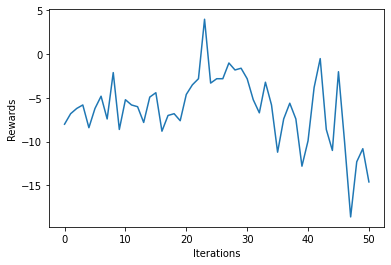

  5%|███▉                                                                          | 512/10000 [00:28<14:59, 10.55it/s]

Mean Reward = -15.5
2


  5%|████                                                                          | 522/10000 [00:30<15:31, 10.17it/s]

Mean Reward = -22.2
0


  5%|████                                                                          | 528/10000 [00:30<14:31, 10.86it/s]

Updated Weights


  5%|████▏                                                                         | 532/10000 [00:30<14:16, 11.06it/s]

Mean Reward = -12.6
0


  5%|████▏                                                                         | 542/10000 [00:31<14:10, 11.12it/s]

Mean Reward = -18.6
0


  6%|████▎                                                                         | 552/10000 [00:32<14:10, 11.11it/s]

Updated Weights
Mean Reward = -14.2
0


  6%|████▍                                                                         | 562/10000 [00:33<14:10, 11.09it/s]

Mean Reward = -20.0
0


  6%|████▍                                                                         | 572/10000 [00:34<12:29, 12.57it/s]

Mean Reward = -18.2
0


  6%|████▍                                                                         | 576/10000 [00:34<13:52, 11.32it/s]

Updated Weights


  6%|████▌                                                                         | 582/10000 [00:35<14:19, 10.95it/s]

Mean Reward = -22.3
1


  6%|████▌                                                                         | 592/10000 [00:36<13:31, 11.59it/s]

Mean Reward = -3.4
1


  6%|████▋                                                                         | 602/10000 [00:37<14:28, 10.82it/s]

Updated Weights
Mean Reward = -3.4
0


  6%|████▊                                                                         | 612/10000 [00:38<15:03, 10.39it/s]

Mean Reward = -4.4
0


  6%|████▊                                                                         | 622/10000 [00:39<14:06, 11.08it/s]

Mean Reward = -12.0
1


  6%|████▉                                                                         | 626/10000 [00:39<14:22, 10.86it/s]

Updated Weights


  6%|████▉                                                                         | 632/10000 [00:40<15:17, 10.21it/s]

Mean Reward = 0.4
1


  6%|█████                                                                         | 642/10000 [00:41<15:17, 10.20it/s]

Mean Reward = -20.2
0


  7%|█████                                                                         | 652/10000 [00:41<13:34, 11.47it/s]

Updated Weights
Mean Reward = -13.6
2


  7%|█████▏                                                                        | 662/10000 [00:42<15:37,  9.96it/s]

Mean Reward = -27.8
0


  7%|█████▏                                                                        | 672/10000 [00:43<15:33,  9.99it/s]

Mean Reward = -28.2
0


  7%|█████▎                                                                        | 676/10000 [00:44<15:49,  9.82it/s]

Updated Weights


  7%|█████▎                                                                        | 682/10000 [00:44<15:44,  9.87it/s]

Mean Reward = -15.2
0


  7%|█████▍                                                                        | 692/10000 [00:45<14:44, 10.52it/s]

Mean Reward = -16.9
1


  7%|█████▍                                                                        | 702/10000 [00:46<15:19, 10.11it/s]

Updated Weights
Mean Reward = -25.4
0


  7%|█████▌                                                                        | 712/10000 [00:47<16:31,  9.36it/s]

Mean Reward = -23.0
0


  7%|█████▌                                                                        | 721/10000 [00:48<17:09,  9.01it/s]

Mean Reward = -16.0
0


  7%|█████▋                                                                        | 727/10000 [00:49<14:34, 10.60it/s]

Updated Weights


  7%|█████▋                                                                        | 731/10000 [00:49<15:26, 10.01it/s]

Mean Reward = -20.3
1


  7%|█████▊                                                                        | 741/10000 [00:50<16:02,  9.62it/s]

Mean Reward = -29.8
0


  8%|█████▊                                                                        | 753/10000 [00:52<15:37,  9.86it/s]

Updated Weights
Mean Reward = 0.0
1


  8%|█████▉                                                                        | 762/10000 [00:53<16:43,  9.20it/s]

Mean Reward = -25.0
0


  8%|██████                                                                        | 771/10000 [00:54<16:32,  9.29it/s]

Mean Reward = -25.4
0


  8%|██████                                                                        | 778/10000 [00:54<16:49,  9.14it/s]

Updated Weights


  8%|██████                                                                        | 782/10000 [00:55<16:33,  9.28it/s]

Mean Reward = -28.6
0


  8%|██████▏                                                                       | 792/10000 [00:56<16:45,  9.16it/s]

Mean Reward = -27.8
0


  8%|██████▎                                                                       | 802/10000 [00:57<17:06,  8.96it/s]

Updated Weights
Mean Reward = -27.0
0


  8%|██████▎                                                                       | 812/10000 [00:58<16:49,  9.10it/s]

Mean Reward = -25.2
0


  8%|██████▍                                                                       | 822/10000 [00:59<16:32,  9.25it/s]

Mean Reward = -31.8
0


  8%|██████▍                                                                       | 827/10000 [01:00<17:22,  8.80it/s]

Updated Weights


  8%|██████▍                                                                       | 832/10000 [01:00<17:02,  8.97it/s]

Mean Reward = -28.4
0


  8%|██████▌                                                                       | 842/10000 [01:01<16:47,  9.09it/s]

Mean Reward = -9.0
0


  9%|██████▋                                                                       | 852/10000 [01:02<17:07,  8.90it/s]

Updated Weights
Mean Reward = -26.8
0


  9%|██████▋                                                                       | 862/10000 [01:04<17:17,  8.81it/s]

Mean Reward = -31.6
0


  9%|██████▊                                                                       | 872/10000 [01:05<17:58,  8.46it/s]

Mean Reward = -30.2
0


  9%|██████▊                                                                       | 876/10000 [01:05<15:59,  9.50it/s]

Updated Weights


  9%|██████▉                                                                       | 882/10000 [01:06<16:32,  9.19it/s]

Mean Reward = -19.3
1


  9%|██████▉                                                                       | 892/10000 [01:07<16:49,  9.02it/s]

Mean Reward = -31.6
0


  9%|███████                                                                       | 902/10000 [01:08<16:19,  9.29it/s]

Updated Weights
Mean Reward = -29.6
1


  9%|███████                                                                       | 912/10000 [01:09<15:22,  9.85it/s]

Mean Reward = -26.7
1


  9%|███████▏                                                                      | 922/10000 [01:10<17:14,  8.77it/s]

Mean Reward = -25.4
0


  9%|███████▏                                                                      | 928/10000 [01:11<16:52,  8.96it/s]

Updated Weights


  9%|███████▎                                                                      | 932/10000 [01:11<17:21,  8.70it/s]

Mean Reward = -29.0
0


  9%|███████▎                                                                      | 942/10000 [01:13<16:30,  9.15it/s]

Mean Reward = -27.0
0


 10%|███████▍                                                                      | 951/10000 [01:13<14:57, 10.08it/s]

Updated Weights
Mean Reward = -29.3
1


 10%|███████▍                                                                      | 961/10000 [01:15<15:51,  9.50it/s]

Mean Reward = -19.8
1


 10%|███████▌                                                                      | 972/10000 [01:16<18:27,  8.15it/s]

Mean Reward = -27.4
0


 10%|███████▌                                                                      | 977/10000 [01:17<17:25,  8.63it/s]

Updated Weights


 10%|███████▋                                                                      | 982/10000 [01:17<17:55,  8.39it/s]

Mean Reward = -33.2
0


 10%|███████▋                                                                      | 992/10000 [01:18<17:33,  8.55it/s]

Mean Reward = -30.4
0


 10%|███████▋                                                                     | 1000/10000 [01:19<16:47,  8.93it/s]

Updated Weights
Mean Reward = -26.4
0


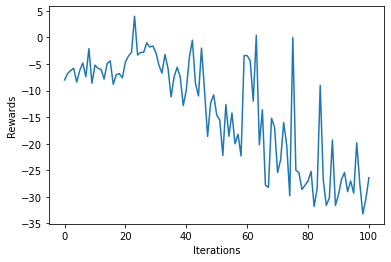

 10%|███████▊                                                                     | 1012/10000 [01:21<17:12,  8.70it/s]

Mean Reward = -30.0
0


 10%|███████▉                                                                     | 1023/10000 [01:22<15:16,  9.79it/s]

Mean Reward = -27.8
0


 10%|███████▉                                                                     | 1027/10000 [01:22<16:29,  9.07it/s]

Updated Weights


 10%|███████▉                                                                     | 1032/10000 [01:23<17:31,  8.53it/s]

Mean Reward = -30.8
1


 10%|████████                                                                     | 1042/10000 [01:24<17:29,  8.53it/s]

Mean Reward = -29.4
0


 11%|████████                                                                     | 1052/10000 [01:25<18:00,  8.28it/s]

Updated Weights
Mean Reward = -27.8
0


 11%|████████▏                                                                    | 1062/10000 [01:27<17:37,  8.45it/s]

Mean Reward = -19.8
0


 11%|████████▎                                                                    | 1072/10000 [01:28<17:28,  8.52it/s]

Mean Reward = -34.8
0


 11%|████████▎                                                                    | 1077/10000 [01:28<20:29,  7.26it/s]

Updated Weights


 11%|████████▎                                                                    | 1082/10000 [01:29<18:01,  8.25it/s]

Mean Reward = -24.0
0


 11%|████████▍                                                                    | 1092/10000 [01:30<17:30,  8.48it/s]

Mean Reward = -25.4
0


 11%|████████▍                                                                    | 1102/10000 [01:31<18:12,  8.14it/s]

Updated Weights
Mean Reward = -34.2
0


 11%|████████▌                                                                    | 1112/10000 [01:33<20:37,  7.18it/s]

Mean Reward = -32.2
0


 11%|████████▋                                                                    | 1122/10000 [01:34<20:58,  7.05it/s]

Mean Reward = -24.8
1


 11%|████████▋                                                                    | 1127/10000 [01:35<22:28,  6.58it/s]

Updated Weights


 11%|████████▋                                                                    | 1132/10000 [01:36<22:23,  6.60it/s]

Mean Reward = -35.0
0


 11%|████████▊                                                                    | 1142/10000 [01:37<23:08,  6.38it/s]

Mean Reward = -34.0
0


 12%|████████▊                                                                    | 1152/10000 [01:39<21:36,  6.83it/s]

Updated Weights
Mean Reward = -22.8
0


 12%|████████▉                                                                    | 1162/10000 [01:40<18:38,  7.90it/s]

Mean Reward = -14.7
1


 12%|█████████                                                                    | 1172/10000 [01:41<18:42,  7.86it/s]

Mean Reward = -18.8
0


 12%|█████████                                                                    | 1177/10000 [01:42<19:31,  7.53it/s]

Updated Weights


 12%|█████████                                                                    | 1182/10000 [01:43<21:07,  6.95it/s]

Mean Reward = -25.6
0


 12%|█████████▏                                                                   | 1192/10000 [01:44<20:43,  7.09it/s]

Mean Reward = -33.2
0


 12%|█████████▎                                                                   | 1202/10000 [01:46<22:07,  6.63it/s]

Updated Weights
Mean Reward = -35.0
0


 12%|█████████▎                                                                   | 1212/10000 [01:47<22:51,  6.41it/s]

Mean Reward = -33.4
0


 12%|█████████▍                                                                   | 1222/10000 [01:49<22:43,  6.44it/s]

Mean Reward = -29.3
1


 12%|█████████▍                                                                   | 1227/10000 [01:49<22:50,  6.40it/s]

Updated Weights


 12%|█████████▍                                                                   | 1232/10000 [01:50<19:29,  7.50it/s]

Mean Reward = -32.4
0


 12%|█████████▌                                                                   | 1242/10000 [01:51<19:10,  7.61it/s]

Mean Reward = -27.3
1


 13%|█████████▋                                                                   | 1252/10000 [01:53<18:54,  7.71it/s]

Updated Weights
Mean Reward = -35.8
0


 13%|█████████▋                                                                   | 1262/10000 [01:54<17:27,  8.35it/s]

Mean Reward = -31.3
1


 13%|█████████▊                                                                   | 1272/10000 [01:55<19:24,  7.49it/s]

Mean Reward = -31.8
0


 13%|█████████▊                                                                   | 1277/10000 [01:56<18:51,  7.71it/s]

Updated Weights


 13%|█████████▊                                                                   | 1282/10000 [01:56<18:57,  7.67it/s]

Mean Reward = -31.6
0


 13%|█████████▉                                                                   | 1292/10000 [01:58<20:44,  7.00it/s]

Mean Reward = -29.4
0


 13%|██████████                                                                   | 1302/10000 [01:59<19:50,  7.31it/s]

Updated Weights
Mean Reward = -36.2
0


 13%|██████████                                                                   | 1312/10000 [02:01<21:49,  6.63it/s]

Mean Reward = -35.2
0


 13%|██████████▏                                                                  | 1322/10000 [02:02<19:05,  7.58it/s]

Mean Reward = -33.6
0


 13%|██████████▏                                                                  | 1327/10000 [02:03<19:11,  7.53it/s]

Updated Weights


 13%|██████████▎                                                                  | 1332/10000 [02:03<18:59,  7.60it/s]

Mean Reward = -38.0
0


 13%|██████████▎                                                                  | 1342/10000 [02:05<18:52,  7.64it/s]

Mean Reward = -17.8
0


 14%|██████████▍                                                                  | 1352/10000 [02:06<18:54,  7.63it/s]

Updated Weights
Mean Reward = -35.2
0


 14%|██████████▍                                                                  | 1362/10000 [02:07<17:55,  8.03it/s]

Mean Reward = -7.5
1


 14%|██████████▌                                                                  | 1372/10000 [02:09<18:22,  7.83it/s]

Mean Reward = -26.8
0


 14%|██████████▌                                                                  | 1377/10000 [02:09<18:35,  7.73it/s]

Updated Weights


 14%|██████████▋                                                                  | 1382/10000 [02:10<18:47,  7.65it/s]

Mean Reward = -36.2
0


 14%|██████████▋                                                                  | 1393/10000 [02:11<16:51,  8.51it/s]

Mean Reward = -34.0
0


 14%|██████████▊                                                                  | 1402/10000 [02:12<18:43,  7.65it/s]

Updated Weights
Mean Reward = -26.3
2


 14%|██████████▊                                                                  | 1412/10000 [02:14<19:21,  7.39it/s]

Mean Reward = -35.6
0


 14%|██████████▉                                                                  | 1422/10000 [02:15<18:35,  7.69it/s]

Mean Reward = -36.2
0


 14%|██████████▉                                                                  | 1427/10000 [02:16<18:38,  7.67it/s]

Updated Weights


 14%|███████████                                                                  | 1432/10000 [02:16<18:45,  7.61it/s]

Mean Reward = -32.0
0


 14%|███████████                                                                  | 1442/10000 [02:18<19:52,  7.18it/s]

Mean Reward = -25.2
0


 15%|███████████▏                                                                 | 1452/10000 [02:19<18:39,  7.64it/s]

Updated Weights
Mean Reward = -18.6
0


 15%|███████████▎                                                                 | 1462/10000 [02:20<18:27,  7.71it/s]

Mean Reward = -16.0
0


 15%|███████████▎                                                                 | 1472/10000 [02:22<16:35,  8.56it/s]

Mean Reward = -24.9
1


 15%|███████████▎                                                                 | 1477/10000 [02:22<19:49,  7.16it/s]

Updated Weights


 15%|███████████▍                                                                 | 1482/10000 [02:23<21:00,  6.76it/s]

Mean Reward = -22.2
0


 15%|███████████▍                                                                 | 1492/10000 [02:24<18:52,  7.51it/s]

Mean Reward = -27.2
0


 15%|███████████▌                                                                 | 1500/10000 [02:25<19:44,  7.18it/s]

Updated Weights
Mean Reward = -36.4
0


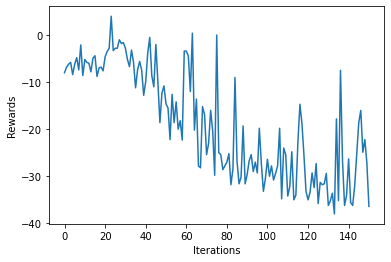

 15%|███████████▋                                                                 | 1512/10000 [02:27<19:00,  7.44it/s]

Mean Reward = -33.6
0


 15%|███████████▋                                                                 | 1522/10000 [02:29<19:13,  7.35it/s]

Mean Reward = -21.8
0


 15%|███████████▊                                                                 | 1527/10000 [02:29<21:14,  6.65it/s]

Updated Weights


 15%|███████████▊                                                                 | 1532/10000 [02:30<22:03,  6.40it/s]

Mean Reward = -37.6
0


 15%|███████████▊                                                                 | 1542/10000 [02:31<19:42,  7.15it/s]

Mean Reward = -20.7
1


 16%|███████████▉                                                                 | 1552/10000 [02:33<18:59,  7.42it/s]

Updated Weights
Mean Reward = -33.4
0


 16%|████████████                                                                 | 1562/10000 [02:34<18:28,  7.61it/s]

Mean Reward = -37.6
0


 16%|████████████                                                                 | 1572/10000 [02:35<18:31,  7.58it/s]

Mean Reward = -30.4
0


 16%|████████████▏                                                                | 1577/10000 [02:36<18:12,  7.71it/s]

Updated Weights


 16%|████████████▏                                                                | 1582/10000 [02:37<18:08,  7.73it/s]

Mean Reward = -23.6
0


 16%|████████████▎                                                                | 1592/10000 [02:38<18:00,  7.78it/s]

Mean Reward = -18.4
0


 16%|████████████▎                                                                | 1602/10000 [02:39<18:44,  7.47it/s]

Updated Weights
Mean Reward = -34.2
0


 16%|████████████▍                                                                | 1612/10000 [02:41<19:08,  7.31it/s]

Mean Reward = -29.4
0


 16%|████████████▍                                                                | 1622/10000 [02:42<18:34,  7.51it/s]

Mean Reward = -21.6
0


 16%|████████████▌                                                                | 1627/10000 [02:43<20:36,  6.77it/s]

Updated Weights


 16%|████████████▌                                                                | 1632/10000 [02:43<20:29,  6.81it/s]

Mean Reward = -28.2
0


 16%|████████████▋                                                                | 1642/10000 [02:45<19:55,  6.99it/s]

Mean Reward = -33.6
0


 17%|████████████▋                                                                | 1652/10000 [02:46<19:58,  6.97it/s]

Updated Weights
Mean Reward = -20.4
0


 17%|████████████▊                                                                | 1662/10000 [02:48<18:42,  7.43it/s]

Mean Reward = -25.4
0


 17%|████████████▊                                                                | 1672/10000 [02:49<19:06,  7.26it/s]

Mean Reward = -23.2
0


 17%|████████████▉                                                                | 1677/10000 [02:49<16:41,  8.31it/s]

Updated Weights


 17%|████████████▉                                                                | 1682/10000 [02:50<18:21,  7.55it/s]

Mean Reward = -24.6
1


 17%|█████████████                                                                | 1692/10000 [02:52<19:24,  7.13it/s]

Mean Reward = -28.6
0


 17%|█████████████                                                                | 1702/10000 [02:53<19:10,  7.22it/s]

Updated Weights
Mean Reward = -34.0
0


 17%|█████████████▏                                                               | 1712/10000 [02:54<18:54,  7.30it/s]

Mean Reward = -25.6
0


 17%|█████████████▎                                                               | 1722/10000 [02:56<18:57,  7.28it/s]

Mean Reward = -24.2
0


 17%|█████████████▎                                                               | 1727/10000 [02:56<20:16,  6.80it/s]

Updated Weights


 17%|█████████████▎                                                               | 1732/10000 [02:57<17:54,  7.69it/s]

Mean Reward = -28.9
1


 17%|█████████████▍                                                               | 1742/10000 [02:58<21:15,  6.47it/s]

Mean Reward = -28.6
0


 18%|█████████████▍                                                               | 1752/10000 [03:00<20:32,  6.69it/s]

Updated Weights
Mean Reward = -31.2
0


 18%|█████████████▌                                                               | 1762/10000 [03:01<18:22,  7.48it/s]

Mean Reward = -30.6
0


 18%|█████████████▋                                                               | 1772/10000 [03:03<18:22,  7.46it/s]

Mean Reward = -30.6
0


 18%|█████████████▋                                                               | 1777/10000 [03:03<18:02,  7.60it/s]

Updated Weights


 18%|█████████████▋                                                               | 1782/10000 [03:04<18:56,  7.23it/s]

Mean Reward = -33.6
0


 18%|█████████████▊                                                               | 1792/10000 [03:05<19:56,  6.86it/s]

Mean Reward = -34.6
0


 18%|█████████████▉                                                               | 1802/10000 [03:07<18:58,  7.20it/s]

Updated Weights
Mean Reward = -36.4
0


 18%|█████████████▉                                                               | 1812/10000 [03:08<19:59,  6.83it/s]

Mean Reward = -31.2
1


 18%|██████████████                                                               | 1822/10000 [03:10<21:40,  6.29it/s]

Mean Reward = -38.0
0


 18%|██████████████                                                               | 1827/10000 [03:11<18:42,  7.28it/s]

Updated Weights


 18%|██████████████                                                               | 1832/10000 [03:11<18:03,  7.54it/s]

Mean Reward = -37.6
0


 18%|██████████████▏                                                              | 1842/10000 [03:13<21:52,  6.22it/s]

Mean Reward = -36.2
0


 19%|██████████████▎                                                              | 1852/10000 [03:14<19:25,  6.99it/s]

Updated Weights
Mean Reward = -28.7
1


 19%|██████████████▎                                                              | 1862/10000 [03:16<20:28,  6.62it/s]

Mean Reward = -26.4
1


 19%|██████████████▍                                                              | 1872/10000 [03:17<19:32,  6.93it/s]

Mean Reward = -28.6
0


 19%|██████████████▍                                                              | 1877/10000 [03:18<21:18,  6.36it/s]

Updated Weights


 19%|██████████████▍                                                              | 1882/10000 [03:19<20:04,  6.74it/s]

Mean Reward = -36.8
0


 19%|██████████████▌                                                              | 1892/10000 [03:20<21:19,  6.34it/s]

Mean Reward = -38.4
0


 19%|██████████████▋                                                              | 1902/10000 [03:22<22:17,  6.05it/s]

Updated Weights
Mean Reward = -38.2
0


 19%|██████████████▋                                                              | 1912/10000 [03:23<16:45,  8.04it/s]

Mean Reward = -28.0
1


 19%|██████████████▊                                                              | 1922/10000 [03:24<17:38,  7.63it/s]

Mean Reward = -38.8
0


 19%|██████████████▊                                                              | 1927/10000 [03:25<18:53,  7.12it/s]

Updated Weights


 19%|██████████████▉                                                              | 1932/10000 [03:26<16:16,  8.26it/s]

Mean Reward = -38.2
0


 19%|██████████████▉                                                              | 1943/10000 [03:27<12:24, 10.83it/s]

Mean Reward = -26.4
0


 20%|███████████████                                                              | 1951/10000 [03:28<13:11, 10.16it/s]

Updated Weights
Mean Reward = -30.4
1


 20%|███████████████                                                              | 1962/10000 [03:29<16:19,  8.20it/s]

Mean Reward = -33.0
0


 20%|███████████████▏                                                             | 1972/10000 [03:30<16:17,  8.22it/s]

Mean Reward = -31.4
0


 20%|███████████████▏                                                             | 1977/10000 [03:31<15:36,  8.57it/s]

Updated Weights


 20%|███████████████▎                                                             | 1982/10000 [03:31<16:36,  8.05it/s]

Mean Reward = -33.1
1


 20%|███████████████▎                                                             | 1992/10000 [03:32<14:12,  9.40it/s]

Mean Reward = -34.6
0


 20%|███████████████▍                                                             | 2000/10000 [03:33<14:20,  9.30it/s]

Updated Weights
Mean Reward = -37.4
0


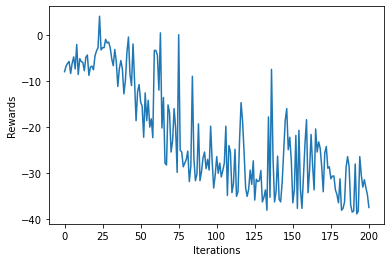

 20%|███████████████▌                                                             | 2013/10000 [03:35<13:24,  9.93it/s]

Mean Reward = -32.0
0


 20%|███████████████▌                                                             | 2022/10000 [03:36<13:25,  9.91it/s]

Mean Reward = -20.4
0


 20%|███████████████▌                                                             | 2027/10000 [03:36<13:47,  9.64it/s]

Updated Weights


 20%|███████████████▋                                                             | 2032/10000 [03:37<13:16, 10.01it/s]

Mean Reward = -26.6
0


 20%|███████████████▋                                                             | 2041/10000 [03:38<13:46,  9.62it/s]

Mean Reward = -37.0
0


 21%|███████████████▊                                                             | 2052/10000 [03:39<13:36,  9.73it/s]

Updated Weights
Mean Reward = -34.4
0


 21%|███████████████▉                                                             | 2062/10000 [03:40<14:17,  9.25it/s]

Mean Reward = -31.6
0


 21%|███████████████▉                                                             | 2072/10000 [03:41<13:15,  9.97it/s]

Mean Reward = -6.0
0


 21%|████████████████                                                             | 2078/10000 [03:41<12:42, 10.39it/s]

Updated Weights


 21%|████████████████                                                             | 2082/10000 [03:42<12:46, 10.33it/s]

Mean Reward = -23.2
0


 21%|████████████████                                                             | 2092/10000 [03:43<15:28,  8.52it/s]

Mean Reward = -34.2
0


 21%|████████████████▏                                                            | 2102/10000 [03:44<17:03,  7.71it/s]

Updated Weights
Mean Reward = -35.0
0


 21%|████████████████▎                                                            | 2112/10000 [03:45<16:38,  7.90it/s]

Mean Reward = -38.8
0


 21%|████████████████▎                                                            | 2122/10000 [03:46<15:34,  8.43it/s]

Mean Reward = -30.7
1


 21%|████████████████▍                                                            | 2127/10000 [03:47<15:42,  8.35it/s]

Updated Weights


 21%|████████████████▍                                                            | 2133/10000 [03:48<14:31,  9.03it/s]

Mean Reward = -34.6
0


 21%|████████████████▌                                                            | 2143/10000 [03:49<13:38,  9.59it/s]

Mean Reward = -35.2
0


 22%|████████████████▌                                                            | 2152/10000 [03:50<13:01, 10.05it/s]

Updated Weights
Mean Reward = -38.8
0


 22%|████████████████▋                                                            | 2162/10000 [03:51<14:42,  8.88it/s]

Mean Reward = -32.0
0


 22%|████████████████▋                                                            | 2172/10000 [03:52<12:30, 10.44it/s]

Mean Reward = -22.5
1


 22%|████████████████▊                                                            | 2176/10000 [03:52<13:05,  9.96it/s]

Updated Weights


 22%|████████████████▊                                                            | 2182/10000 [03:53<13:06,  9.94it/s]

Mean Reward = -35.8
0


 22%|████████████████▉                                                            | 2192/10000 [03:54<12:41, 10.26it/s]

Mean Reward = -38.4
0


 22%|████████████████▉                                                            | 2202/10000 [03:55<13:38,  9.52it/s]

Updated Weights
Mean Reward = -38.8
0


 22%|█████████████████                                                            | 2211/10000 [03:56<12:58, 10.00it/s]

Mean Reward = -34.0
0


 22%|█████████████████                                                            | 2222/10000 [03:57<12:33, 10.32it/s]

Mean Reward = -34.2
0


 22%|█████████████████▏                                                           | 2227/10000 [03:57<13:13,  9.79it/s]

Updated Weights


 22%|█████████████████▏                                                           | 2231/10000 [03:58<12:49, 10.10it/s]

Mean Reward = -38.8
0


 22%|█████████████████▎                                                           | 2243/10000 [03:59<12:28, 10.36it/s]

Mean Reward = -20.2
0


 23%|█████████████████▎                                                           | 2253/10000 [04:00<12:23, 10.42it/s]

Updated Weights
Mean Reward = -23.0
0


 23%|█████████████████▍                                                           | 2263/10000 [04:01<12:23, 10.41it/s]

Mean Reward = -27.4
0


 23%|█████████████████▍                                                           | 2271/10000 [04:02<12:55,  9.97it/s]

Mean Reward = -30.4
0


 23%|█████████████████▌                                                           | 2277/10000 [04:02<14:41,  8.76it/s]

Updated Weights


 23%|█████████████████▌                                                           | 2282/10000 [04:03<15:02,  8.55it/s]

Mean Reward = -28.4
0


 23%|█████████████████▋                                                           | 2293/10000 [04:04<13:44,  9.34it/s]

Mean Reward = -8.8
0


 23%|█████████████████▋                                                           | 2303/10000 [04:05<13:24,  9.56it/s]

Updated Weights
Mean Reward = -26.6
0


 23%|█████████████████▊                                                           | 2311/10000 [04:06<13:13,  9.69it/s]

Mean Reward = -37.6
0


 23%|█████████████████▉                                                           | 2322/10000 [04:07<13:29,  9.49it/s]

Mean Reward = -37.2
0


 23%|█████████████████▉                                                           | 2327/10000 [04:08<13:15,  9.64it/s]

Updated Weights


 23%|█████████████████▉                                                           | 2332/10000 [04:08<14:11,  9.00it/s]

Mean Reward = -39.0
0


 23%|██████████████████                                                           | 2342/10000 [04:09<14:40,  8.70it/s]

Mean Reward = -37.8
0


 24%|██████████████████                                                           | 2351/10000 [04:10<11:25, 11.16it/s]

Updated Weights
Mean Reward = -34.6
1


 24%|██████████████████▏                                                          | 2361/10000 [04:11<13:31,  9.41it/s]

Mean Reward = -39.0
0


 24%|██████████████████▎                                                          | 2372/10000 [04:12<14:48,  8.58it/s]

Mean Reward = -37.2
0


 24%|██████████████████▎                                                          | 2377/10000 [04:13<12:43,  9.98it/s]

Updated Weights


 24%|██████████████████▎                                                          | 2381/10000 [04:13<13:32,  9.37it/s]

Mean Reward = -29.7
2


 24%|██████████████████▍                                                          | 2391/10000 [04:14<14:28,  8.76it/s]

Mean Reward = -34.2
0


 24%|██████████████████▍                                                          | 2402/10000 [04:16<15:16,  8.29it/s]

Updated Weights
Mean Reward = -33.5
1


 24%|██████████████████▌                                                          | 2412/10000 [04:17<14:59,  8.43it/s]

Mean Reward = -39.2
0


 24%|██████████████████▋                                                          | 2422/10000 [04:18<13:11,  9.57it/s]

Mean Reward = -39.4
0


 24%|██████████████████▋                                                          | 2427/10000 [04:18<13:19,  9.47it/s]

Updated Weights


 24%|██████████████████▋                                                          | 2431/10000 [04:19<12:57,  9.73it/s]

Mean Reward = -39.2
0


 24%|██████████████████▊                                                          | 2442/10000 [04:20<12:39,  9.96it/s]

Mean Reward = -34.2
0


 25%|██████████████████▉                                                          | 2452/10000 [04:21<12:50,  9.79it/s]

Updated Weights
Mean Reward = -38.2
0


 25%|██████████████████▉                                                          | 2462/10000 [04:22<13:07,  9.57it/s]

Mean Reward = -21.2
0


 25%|███████████████████                                                          | 2471/10000 [04:23<15:01,  8.35it/s]

Mean Reward = -39.4
0


 25%|███████████████████                                                          | 2477/10000 [04:24<14:43,  8.52it/s]

Updated Weights


 25%|███████████████████                                                          | 2482/10000 [04:24<15:02,  8.33it/s]

Mean Reward = -36.2
0


 25%|███████████████████▏                                                         | 2492/10000 [04:26<16:34,  7.55it/s]

Mean Reward = -13.0
0


 25%|███████████████████▎                                                         | 2500/10000 [04:27<13:57,  8.96it/s]

Updated Weights
Mean Reward = -27.8
0


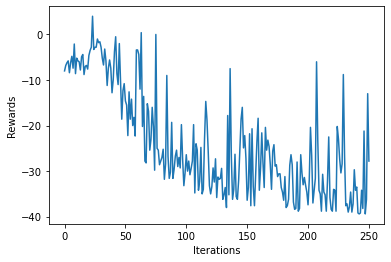

 25%|███████████████████▎                                                         | 2512/10000 [04:28<14:14,  8.76it/s]

Mean Reward = -35.6
0


 25%|███████████████████▍                                                         | 2522/10000 [04:29<13:41,  9.10it/s]

Mean Reward = -27.2
0


 25%|███████████████████▍                                                         | 2527/10000 [04:30<13:15,  9.39it/s]

Updated Weights


 25%|███████████████████▍                                                         | 2532/10000 [04:30<13:56,  8.93it/s]

Mean Reward = -39.2
0


 25%|███████████████████▌                                                         | 2542/10000 [04:31<13:16,  9.36it/s]

Mean Reward = -39.6
0


 26%|███████████████████▋                                                         | 2551/10000 [04:32<12:27,  9.97it/s]

Updated Weights
Mean Reward = -33.7
1


 26%|███████████████████▋                                                         | 2562/10000 [04:33<13:07,  9.45it/s]

Mean Reward = -20.4
0


 26%|███████████████████▊                                                         | 2572/10000 [04:35<13:15,  9.33it/s]

Mean Reward = -36.4
0


 26%|███████████████████▊                                                         | 2576/10000 [04:35<13:31,  9.15it/s]

Updated Weights


 26%|███████████████████▉                                                         | 2582/10000 [04:36<12:53,  9.59it/s]

Mean Reward = -31.2
0


 26%|███████████████████▉                                                         | 2592/10000 [04:37<13:12,  9.35it/s]

Mean Reward = -20.0
0


 26%|████████████████████                                                         | 2602/10000 [04:38<13:31,  9.11it/s]

Updated Weights
Mean Reward = -31.4
0


 26%|████████████████████                                                         | 2612/10000 [04:39<15:26,  7.97it/s]

Mean Reward = -19.0
0


 26%|████████████████████▏                                                        | 2622/10000 [04:40<18:25,  6.68it/s]

Mean Reward = -35.8
0


 26%|████████████████████▏                                                        | 2627/10000 [04:41<19:01,  6.46it/s]

Updated Weights


 26%|████████████████████▎                                                        | 2632/10000 [04:42<17:40,  6.95it/s]

Mean Reward = -16.2
0


 26%|████████████████████▎                                                        | 2642/10000 [04:43<20:11,  6.07it/s]

Mean Reward = -30.4
0


 27%|████████████████████▍                                                        | 2652/10000 [04:45<19:24,  6.31it/s]

Updated Weights
Mean Reward = -39.0
0


 27%|████████████████████▍                                                        | 2662/10000 [04:46<17:44,  6.89it/s]

Mean Reward = -35.0
0


 27%|████████████████████▌                                                        | 2672/10000 [04:48<17:21,  7.03it/s]

Mean Reward = -33.4
1


 27%|████████████████████▌                                                        | 2676/10000 [04:48<18:52,  6.47it/s]

Updated Weights


 27%|████████████████████▋                                                        | 2682/10000 [04:49<18:08,  6.72it/s]

Mean Reward = -38.8
0


 27%|████████████████████▋                                                        | 2691/10000 [04:51<21:01,  5.79it/s]

Mean Reward = -39.0
0


 27%|████████████████████▊                                                        | 2702/10000 [04:52<17:05,  7.12it/s]

Updated Weights
Mean Reward = -31.6
0


 27%|████████████████████▉                                                        | 2712/10000 [04:54<21:40,  5.60it/s]

Mean Reward = -20.2
0


 27%|████████████████████▉                                                        | 2722/10000 [04:56<18:46,  6.46it/s]

Mean Reward = -34.1
1


 27%|████████████████████▉                                                        | 2727/10000 [04:56<18:56,  6.40it/s]

Updated Weights


 27%|█████████████████████                                                        | 2732/10000 [04:57<17:37,  6.88it/s]

Mean Reward = -3.8
0


 27%|█████████████████████                                                        | 2742/10000 [04:59<17:11,  7.04it/s]

Mean Reward = -8.0
0


 28%|█████████████████████▏                                                       | 2752/10000 [05:00<17:06,  7.06it/s]

Updated Weights
Mean Reward = -11.6
0


 28%|█████████████████████▎                                                       | 2762/10000 [05:01<17:06,  7.05it/s]

Mean Reward = -27.8
0


 28%|█████████████████████▎                                                       | 2772/10000 [05:03<16:41,  7.22it/s]

Mean Reward = -31.6
0


 28%|█████████████████████▍                                                       | 2777/10000 [05:04<18:33,  6.49it/s]

Updated Weights


 28%|█████████████████████▍                                                       | 2782/10000 [05:04<18:27,  6.51it/s]

Mean Reward = -39.2
0


 28%|█████████████████████▍                                                       | 2792/10000 [05:06<19:06,  6.29it/s]

Mean Reward = -33.8
1


 28%|█████████████████████▌                                                       | 2802/10000 [05:08<19:39,  6.10it/s]

Updated Weights
Mean Reward = -40.0
0


 28%|█████████████████████▋                                                       | 2812/10000 [05:09<20:30,  5.84it/s]

Mean Reward = -39.2
0


 28%|█████████████████████▋                                                       | 2822/10000 [05:11<18:34,  6.44it/s]

Mean Reward = -39.4
0


 28%|█████████████████████▊                                                       | 2827/10000 [05:11<18:06,  6.60it/s]

Updated Weights


 28%|█████████████████████▊                                                       | 2831/10000 [05:12<18:44,  6.37it/s]

Mean Reward = -34.3
1


 28%|█████████████████████▉                                                       | 2842/10000 [05:14<20:32,  5.81it/s]

Mean Reward = -39.6
0


 29%|█████████████████████▉                                                       | 2852/10000 [05:16<20:16,  5.88it/s]

Updated Weights
Mean Reward = -39.0
0


 29%|██████████████████████                                                       | 2862/10000 [05:17<19:30,  6.10it/s]

Mean Reward = -27.8
0


 29%|██████████████████████                                                       | 2872/10000 [05:19<19:04,  6.23it/s]

Mean Reward = -38.8
0


 29%|██████████████████████▏                                                      | 2877/10000 [05:20<18:33,  6.40it/s]

Updated Weights


 29%|██████████████████████▏                                                      | 2882/10000 [05:21<18:23,  6.45it/s]

Mean Reward = -38.6
0


 29%|██████████████████████▎                                                      | 2892/10000 [05:22<18:21,  6.45it/s]

Mean Reward = -26.4
0


 29%|██████████████████████▎                                                      | 2902/10000 [05:24<18:56,  6.24it/s]

Updated Weights
Mean Reward = -35.8
0


 29%|██████████████████████▍                                                      | 2912/10000 [05:25<18:42,  6.31it/s]

Mean Reward = -38.2
0


 29%|██████████████████████▍                                                      | 2922/10000 [05:27<18:11,  6.48it/s]

Mean Reward = -27.6
0


 29%|██████████████████████▌                                                      | 2927/10000 [05:28<18:10,  6.49it/s]

Updated Weights


 29%|██████████████████████▌                                                      | 2932/10000 [05:28<18:41,  6.30it/s]

Mean Reward = -30.6
0


 29%|██████████████████████▋                                                      | 2942/10000 [05:30<18:28,  6.37it/s]

Mean Reward = -31.2
0


 30%|██████████████████████▋                                                      | 2951/10000 [05:31<17:58,  6.53it/s]

Updated Weights
Mean Reward = -29.2
1


 30%|██████████████████████▊                                                      | 2962/10000 [05:33<18:53,  6.21it/s]

Mean Reward = -24.8
0


 30%|██████████████████████▉                                                      | 2972/10000 [05:35<18:38,  6.28it/s]

Mean Reward = -25.7
1


 30%|██████████████████████▉                                                      | 2977/10000 [05:36<18:53,  6.20it/s]

Updated Weights


 30%|██████████████████████▉                                                      | 2982/10000 [05:36<18:05,  6.47it/s]

Mean Reward = -36.6
0


 30%|███████████████████████                                                      | 2992/10000 [05:38<18:50,  6.20it/s]

Mean Reward = -18.1
1


 30%|███████████████████████                                                      | 3000/10000 [05:39<18:27,  6.32it/s]

Updated Weights
Mean Reward = -28.7
1


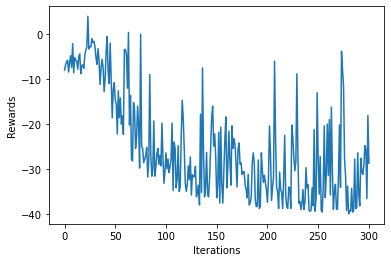

 30%|███████████████████████▏                                                     | 3012/10000 [05:41<19:04,  6.11it/s]

Mean Reward = -15.8
0


 30%|███████████████████████▎                                                     | 3022/10000 [05:43<18:55,  6.15it/s]

Mean Reward = -13.9
1


 30%|███████████████████████▎                                                     | 3027/10000 [05:44<18:56,  6.14it/s]

Updated Weights


 30%|███████████████████████▎                                                     | 3032/10000 [05:44<18:40,  6.22it/s]

Mean Reward = -35.0
0


 30%|███████████████████████▍                                                     | 3042/10000 [05:46<18:08,  6.39it/s]

Mean Reward = -27.6
1


 31%|███████████████████████▌                                                     | 3052/10000 [05:47<18:31,  6.25it/s]

Updated Weights
Mean Reward = -37.8
0


 31%|███████████████████████▌                                                     | 3062/10000 [05:49<18:17,  6.32it/s]

Mean Reward = -36.0
0


 31%|███████████████████████▋                                                     | 3072/10000 [05:51<18:26,  6.26it/s]

Mean Reward = -26.8
0


 31%|███████████████████████▋                                                     | 3077/10000 [05:51<18:37,  6.20it/s]

Updated Weights


 31%|███████████████████████▋                                                     | 3082/10000 [05:52<17:59,  6.41it/s]

Mean Reward = -26.0
0


 31%|███████████████████████▊                                                     | 3092/10000 [05:54<17:46,  6.48it/s]

Mean Reward = -23.8
0


 31%|███████████████████████▉                                                     | 3102/10000 [05:55<18:36,  6.18it/s]

Updated Weights
Mean Reward = -29.4
0


 31%|███████████████████████▉                                                     | 3112/10000 [05:57<17:55,  6.40it/s]

Mean Reward = -15.4
0


 31%|████████████████████████                                                     | 3122/10000 [05:59<19:19,  5.93it/s]

Mean Reward = -20.0
0


 31%|████████████████████████                                                     | 3127/10000 [05:59<18:29,  6.19it/s]

Updated Weights


 31%|████████████████████████                                                     | 3132/10000 [06:00<18:36,  6.15it/s]

Mean Reward = -11.6
0


 31%|████████████████████████▏                                                    | 3142/10000 [06:02<18:10,  6.29it/s]

Mean Reward = -22.8
0


 32%|████████████████████████▎                                                    | 3152/10000 [06:03<18:19,  6.23it/s]

Updated Weights
Mean Reward = -39.4
0


 32%|████████████████████████▎                                                    | 3162/10000 [06:05<19:32,  5.83it/s]

Mean Reward = -39.6
0


 32%|████████████████████████▍                                                    | 3172/10000 [06:07<17:58,  6.33it/s]

Mean Reward = -39.0
0


 32%|████████████████████████▍                                                    | 3177/10000 [06:07<17:56,  6.34it/s]

Updated Weights


 32%|████████████████████████▌                                                    | 3182/10000 [06:08<18:14,  6.23it/s]

Mean Reward = -39.6
0


 32%|████████████████████████▌                                                    | 3192/10000 [06:10<18:19,  6.19it/s]

Mean Reward = -39.4
0


 32%|████████████████████████▋                                                    | 3202/10000 [06:12<19:58,  5.67it/s]

Updated Weights
Mean Reward = -38.2
0


 32%|████████████████████████▋                                                    | 3212/10000 [06:13<18:00,  6.28it/s]

Mean Reward = -39.0
0


 32%|████████████████████████▊                                                    | 3221/10000 [06:15<17:27,  6.47it/s]

Mean Reward = -32.4
1


 32%|████████████████████████▊                                                    | 3227/10000 [06:16<16:25,  6.87it/s]

Updated Weights


 32%|████████████████████████▉                                                    | 3232/10000 [06:16<17:58,  6.28it/s]

Mean Reward = -33.9
1


 32%|████████████████████████▉                                                    | 3242/10000 [06:18<17:56,  6.28it/s]

Mean Reward = -34.8
0


 33%|█████████████████████████                                                    | 3252/10000 [06:20<18:26,  6.10it/s]

Updated Weights
Mean Reward = -39.6
0


 33%|█████████████████████████                                                    | 3262/10000 [06:21<17:49,  6.30it/s]

Mean Reward = -39.2
0


 33%|█████████████████████████▏                                                   | 3272/10000 [06:23<17:55,  6.26it/s]

Mean Reward = -31.4
0


 33%|█████████████████████████▏                                                   | 3277/10000 [06:24<18:17,  6.13it/s]

Updated Weights


 33%|█████████████████████████▎                                                   | 3282/10000 [06:24<17:50,  6.28it/s]

Mean Reward = -37.4
0


 33%|█████████████████████████▎                                                   | 3292/10000 [06:26<18:08,  6.16it/s]

Mean Reward = -23.2
0


 33%|█████████████████████████▍                                                   | 3302/10000 [06:27<17:52,  6.25it/s]

Updated Weights
Mean Reward = -33.2
1


 33%|█████████████████████████▍                                                   | 3311/10000 [06:29<17:41,  6.30it/s]

Mean Reward = -39.2
0


 33%|█████████████████████████▌                                                   | 3322/10000 [06:31<17:33,  6.34it/s]

Mean Reward = -30.6
0


 33%|█████████████████████████▌                                                   | 3327/10000 [06:31<17:34,  6.33it/s]

Updated Weights


 33%|█████████████████████████▋                                                   | 3332/10000 [06:32<17:52,  6.22it/s]

Mean Reward = -26.8
0


 33%|█████████████████████████▋                                                   | 3342/10000 [06:34<18:34,  5.98it/s]

Mean Reward = -39.6
0


 34%|█████████████████████████▊                                                   | 3352/10000 [06:36<17:42,  6.26it/s]

Updated Weights
Mean Reward = -35.2
0


 34%|█████████████████████████▉                                                   | 3363/10000 [06:37<14:54,  7.42it/s]

Mean Reward = -32.0
0


 34%|█████████████████████████▉                                                   | 3372/10000 [06:39<18:28,  5.98it/s]

Mean Reward = -24.5
1


 34%|██████████████████████████                                                   | 3377/10000 [06:40<18:51,  5.85it/s]

Updated Weights


 34%|██████████████████████████                                                   | 3382/10000 [06:40<19:09,  5.76it/s]

Mean Reward = -40.0
0


 34%|██████████████████████████                                                   | 3392/10000 [06:42<17:52,  6.16it/s]

Mean Reward = -39.4
0


 34%|██████████████████████████▏                                                  | 3401/10000 [06:43<20:12,  5.44it/s]

Updated Weights
Mean Reward = -13.1
1


 34%|██████████████████████████▎                                                  | 3412/10000 [06:45<17:42,  6.20it/s]

Mean Reward = -39.4
0


 34%|██████████████████████████▎                                                  | 3422/10000 [06:47<17:32,  6.25it/s]

Mean Reward = -35.0
0


 34%|██████████████████████████▍                                                  | 3427/10000 [06:48<17:31,  6.25it/s]

Updated Weights


 34%|██████████████████████████▍                                                  | 3432/10000 [06:48<17:48,  6.15it/s]

Mean Reward = -30.0
0


 34%|██████████████████████████▌                                                  | 3442/10000 [06:50<17:55,  6.10it/s]

Mean Reward = -25.6
0


 35%|██████████████████████████▌                                                  | 3452/10000 [06:52<16:54,  6.45it/s]

Updated Weights
Mean Reward = -33.5
1


 35%|██████████████████████████▋                                                  | 3462/10000 [06:53<17:38,  6.18it/s]

Mean Reward = -40.0
0


 35%|██████████████████████████▋                                                  | 3472/10000 [06:55<17:21,  6.27it/s]

Mean Reward = -35.6
0


 35%|██████████████████████████▊                                                  | 3477/10000 [06:56<16:54,  6.43it/s]

Updated Weights


 35%|██████████████████████████▊                                                  | 3482/10000 [06:56<17:16,  6.29it/s]

Mean Reward = -38.2
0


 35%|██████████████████████████▉                                                  | 3492/10000 [06:58<17:29,  6.20it/s]

Mean Reward = -26.4
2


 35%|██████████████████████████▉                                                  | 3500/10000 [06:59<17:59,  6.02it/s]

Updated Weights
Mean Reward = -38.8
0


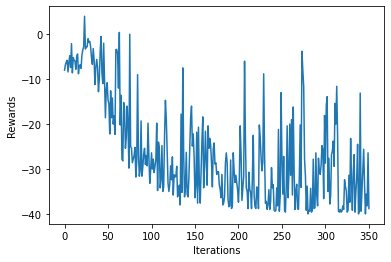

 35%|███████████████████████████                                                  | 3512/10000 [07:01<18:26,  5.86it/s]

Mean Reward = -37.2
0


 35%|███████████████████████████                                                  | 3522/10000 [07:03<14:58,  7.21it/s]

Mean Reward = -29.6
1


 35%|███████████████████████████▏                                                 | 3527/10000 [07:04<17:09,  6.29it/s]

Updated Weights


 35%|███████████████████████████▏                                                 | 3532/10000 [07:04<17:05,  6.31it/s]

Mean Reward = -34.0
0


 35%|███████████████████████████▎                                                 | 3542/10000 [07:06<16:18,  6.60it/s]

Mean Reward = -30.6
0


 36%|███████████████████████████▎                                                 | 3551/10000 [07:08<24:22,  4.41it/s]

Updated Weights
Mean Reward = -28.3
1


 36%|███████████████████████████▍                                                 | 3561/10000 [07:10<22:34,  4.75it/s]

Mean Reward = -28.6
0


 36%|███████████████████████████▍                                                 | 3571/10000 [07:12<21:13,  5.05it/s]

Mean Reward = -30.0
0


 36%|███████████████████████████▌                                                 | 3576/10000 [07:13<20:47,  5.15it/s]

Updated Weights


 36%|███████████████████████████▌                                                 | 3582/10000 [07:14<20:06,  5.32it/s]

Mean Reward = -27.0
0


 36%|███████████████████████████▋                                                 | 3591/10000 [07:16<21:18,  5.01it/s]

Mean Reward = -29.4
0


 36%|███████████████████████████▋                                                 | 3601/10000 [07:18<23:57,  4.45it/s]

Updated Weights
Mean Reward = -37.4
0


 36%|███████████████████████████▊                                                 | 3611/10000 [07:20<20:33,  5.18it/s]

Mean Reward = -33.6
0


 36%|███████████████████████████▉                                                 | 3622/10000 [07:21<16:04,  6.61it/s]

Mean Reward = -30.6
0


 36%|███████████████████████████▉                                                 | 3627/10000 [07:22<14:25,  7.36it/s]

Updated Weights


 36%|███████████████████████████▉                                                 | 3632/10000 [07:23<14:50,  7.15it/s]

Mean Reward = -18.6
1


 36%|████████████████████████████                                                 | 3642/10000 [07:24<14:34,  7.27it/s]

Mean Reward = -38.0
0


 37%|████████████████████████████                                                 | 3652/10000 [07:25<14:17,  7.40it/s]

Updated Weights
Mean Reward = -31.4
0


 37%|████████████████████████████▏                                                | 3662/10000 [07:27<14:27,  7.30it/s]

Mean Reward = -28.4
0


 37%|████████████████████████████▎                                                | 3672/10000 [07:28<14:28,  7.28it/s]

Mean Reward = -39.4
0


 37%|████████████████████████████▎                                                | 3677/10000 [07:29<14:17,  7.37it/s]

Updated Weights


 37%|████████████████████████████▎                                                | 3682/10000 [07:30<14:31,  7.25it/s]

Mean Reward = -33.4
0


 37%|████████████████████████████▍                                                | 3692/10000 [07:31<14:55,  7.04it/s]

Mean Reward = -17.4
0


 37%|████████████████████████████▌                                                | 3702/10000 [07:32<14:53,  7.05it/s]

Updated Weights
Mean Reward = -39.6
0


 37%|████████████████████████████▌                                                | 3712/10000 [07:34<14:17,  7.34it/s]

Mean Reward = -26.6
0


 37%|████████████████████████████▋                                                | 3722/10000 [07:35<14:24,  7.26it/s]

Mean Reward = -17.8
0


 37%|████████████████████████████▋                                                | 3727/10000 [07:36<14:28,  7.22it/s]

Updated Weights


 37%|████████████████████████████▋                                                | 3732/10000 [07:36<14:19,  7.29it/s]

Mean Reward = -24.6
0


 37%|████████████████████████████▊                                                | 3741/10000 [07:38<20:09,  5.18it/s]

Mean Reward = -37.0
0


 38%|████████████████████████████▉                                                | 3751/10000 [07:40<20:23,  5.11it/s]

Updated Weights
Mean Reward = -39.8
0


 38%|████████████████████████████▉                                                | 3760/10000 [07:42<19:49,  5.25it/s]

Mean Reward = -21.2
1


 38%|█████████████████████████████                                                | 3771/10000 [07:43<17:19,  5.99it/s]

Mean Reward = -30.6
0


 38%|█████████████████████████████                                                | 3776/10000 [07:44<20:01,  5.18it/s]

Updated Weights


 38%|█████████████████████████████                                                | 3782/10000 [07:46<20:04,  5.16it/s]

Mean Reward = -20.2
0


 38%|█████████████████████████████▏                                               | 3792/10000 [07:48<19:08,  5.40it/s]

Mean Reward = -29.6
0


 38%|█████████████████████████████▎                                               | 3802/10000 [07:49<17:08,  6.03it/s]

Updated Weights
Mean Reward = -8.4
0


 38%|█████████████████████████████▎                                               | 3812/10000 [07:51<16:21,  6.30it/s]

Mean Reward = -8.2
0


 38%|█████████████████████████████▍                                               | 3821/10000 [07:52<17:51,  5.77it/s]

Mean Reward = -34.2
0


 38%|█████████████████████████████▍                                               | 3826/10000 [07:53<20:18,  5.07it/s]

Updated Weights


 38%|█████████████████████████████▍                                               | 3831/10000 [07:54<24:09,  4.25it/s]

Mean Reward = -36.4
0


 38%|█████████████████████████████▌                                               | 3842/10000 [07:56<17:01,  6.03it/s]

Mean Reward = -38.8
0


 39%|█████████████████████████████▋                                               | 3851/10000 [07:58<20:23,  5.02it/s]

Updated Weights
Mean Reward = -30.3
1


 39%|█████████████████████████████▋                                               | 3862/10000 [08:00<17:57,  5.70it/s]

Mean Reward = -38.4
0


 39%|█████████████████████████████▊                                               | 3872/10000 [08:02<16:15,  6.28it/s]

Mean Reward = -33.0
0


 39%|█████████████████████████████▊                                               | 3877/10000 [08:02<16:12,  6.30it/s]

Updated Weights


 39%|█████████████████████████████▉                                               | 3881/10000 [08:03<18:00,  5.66it/s]

Mean Reward = -37.6
0


 39%|█████████████████████████████▉                                               | 3891/10000 [08:05<20:15,  5.02it/s]

Mean Reward = -34.8
0


 39%|██████████████████████████████                                               | 3901/10000 [08:07<20:40,  4.92it/s]

Updated Weights
Mean Reward = -35.8
0


 39%|██████████████████████████████                                               | 3912/10000 [08:09<17:04,  5.94it/s]

Mean Reward = -39.0
0


 39%|██████████████████████████████▏                                              | 3921/10000 [08:11<16:50,  6.02it/s]

Mean Reward = -38.4
0


 39%|██████████████████████████████▏                                              | 3926/10000 [08:12<19:16,  5.25it/s]

Updated Weights


 39%|██████████████████████████████▎                                              | 3932/10000 [08:13<16:53,  5.99it/s]

Mean Reward = -39.4
0


 39%|██████████████████████████████▎                                              | 3942/10000 [08:14<16:09,  6.25it/s]

Mean Reward = -32.8
0


 40%|██████████████████████████████▍                                              | 3951/10000 [08:16<18:30,  5.45it/s]

Updated Weights
Mean Reward = -36.4
0


 40%|██████████████████████████████▍                                              | 3961/10000 [08:18<21:37,  4.65it/s]

Mean Reward = -34.4
1


 40%|██████████████████████████████▌                                              | 3972/10000 [08:20<17:15,  5.82it/s]

Mean Reward = -37.8
0


 40%|██████████████████████████████▌                                              | 3977/10000 [08:20<16:44,  6.00it/s]

Updated Weights


 40%|██████████████████████████████▋                                              | 3981/10000 [08:21<18:59,  5.28it/s]

Mean Reward = -30.2
0


 40%|██████████████████████████████▋                                              | 3992/10000 [08:23<15:49,  6.33it/s]

Mean Reward = -27.8
0


 40%|██████████████████████████████▊                                              | 4000/10000 [08:24<17:40,  5.66it/s]

Updated Weights
Mean Reward = -33.6
0


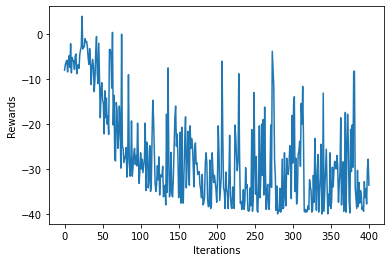

 40%|██████████████████████████████▉                                              | 4011/10000 [08:27<21:04,  4.74it/s]

Mean Reward = -39.6
0


 40%|██████████████████████████████▉                                              | 4021/10000 [08:29<21:20,  4.67it/s]

Mean Reward = -32.2
0


 40%|██████████████████████████████▉                                              | 4025/10000 [08:30<21:30,  4.63it/s]

Updated Weights


 40%|███████████████████████████████                                              | 4032/10000 [08:31<15:50,  6.28it/s]

Mean Reward = -22.2
1


 40%|███████████████████████████████                                              | 4042/10000 [08:32<15:26,  6.43it/s]

Mean Reward = -36.0
0


 41%|███████████████████████████████▏                                             | 4051/10000 [08:34<17:58,  5.51it/s]

Updated Weights
Mean Reward = -25.9
1


 41%|███████████████████████████████▎                                             | 4062/10000 [08:36<15:52,  6.23it/s]

Mean Reward = -39.0
0


 41%|███████████████████████████████▎                                             | 4072/10000 [08:37<14:41,  6.72it/s]

Mean Reward = -28.3
1


 41%|███████████████████████████████▍                                             | 4076/10000 [08:38<15:47,  6.25it/s]

Updated Weights


 41%|███████████████████████████████▍                                             | 4082/10000 [08:39<16:21,  6.03it/s]

Mean Reward = -30.2
1


 41%|███████████████████████████████▌                                             | 4092/10000 [08:40<16:11,  6.08it/s]

Mean Reward = -38.0
0


 41%|███████████████████████████████▌                                             | 4102/10000 [08:42<17:04,  5.76it/s]

Updated Weights
Mean Reward = -18.2
0


 41%|███████████████████████████████▋                                             | 4111/10000 [08:44<17:46,  5.52it/s]

Mean Reward = -39.4
0


 41%|███████████████████████████████▋                                             | 4122/10000 [08:46<16:16,  6.02it/s]

Mean Reward = -38.6
0


 41%|███████████████████████████████▊                                             | 4126/10000 [08:46<19:10,  5.11it/s]

Updated Weights


 41%|███████████████████████████████▊                                             | 4131/10000 [08:47<20:18,  4.82it/s]

Mean Reward = -39.4
0


 41%|███████████████████████████████▉                                             | 4141/10000 [08:50<19:34,  4.99it/s]

Mean Reward = -37.4
0


 42%|███████████████████████████████▉                                             | 4152/10000 [08:52<20:19,  4.80it/s]

Updated Weights
Mean Reward = -0.4
0


 42%|████████████████████████████████                                             | 4161/10000 [08:54<20:07,  4.84it/s]

Mean Reward = -29.3
1


 42%|████████████████████████████████                                             | 4171/10000 [08:56<21:02,  4.62it/s]

Mean Reward = -31.4
0


 42%|████████████████████████████████▏                                            | 4176/10000 [08:57<20:28,  4.74it/s]

Updated Weights


 42%|████████████████████████████████▏                                            | 4181/10000 [08:58<21:44,  4.46it/s]

Mean Reward = -39.4
0


 42%|████████████████████████████████▎                                            | 4191/10000 [09:00<19:07,  5.06it/s]

Mean Reward = -39.6
0


 42%|████████████████████████████████▎                                            | 4201/10000 [09:02<16:39,  5.80it/s]

Updated Weights
Mean Reward = -30.4
0


 42%|████████████████████████████████▍                                            | 4211/10000 [09:04<23:27,  4.11it/s]

Mean Reward = -22.8
0


 42%|████████████████████████████████▌                                            | 4221/10000 [09:06<22:41,  4.24it/s]

Mean Reward = -15.6
0


 42%|████████████████████████████████▌                                            | 4227/10000 [09:07<17:15,  5.57it/s]

Updated Weights


 42%|████████████████████████████████▌                                            | 4232/10000 [09:08<14:25,  6.67it/s]

Mean Reward = -38.8
0


 42%|████████████████████████████████▋                                            | 4242/10000 [09:10<13:57,  6.88it/s]

Mean Reward = -32.8
0


 43%|████████████████████████████████▋                                            | 4252/10000 [09:11<13:33,  7.06it/s]

Updated Weights
Mean Reward = -32.8
0


 43%|████████████████████████████████▊                                            | 4262/10000 [09:12<13:06,  7.29it/s]

Mean Reward = -38.4
0


 43%|████████████████████████████████▉                                            | 4272/10000 [09:14<13:28,  7.08it/s]

Mean Reward = -38.4
0


 43%|████████████████████████████████▉                                            | 4277/10000 [09:15<15:37,  6.10it/s]

Updated Weights


 43%|████████████████████████████████▉                                            | 4281/10000 [09:15<19:20,  4.93it/s]

Mean Reward = -29.2
0


 43%|█████████████████████████████████                                            | 4292/10000 [09:17<13:55,  6.83it/s]

Mean Reward = -21.3
2


 43%|█████████████████████████████████▏                                           | 4302/10000 [09:19<13:46,  6.90it/s]

Updated Weights
Mean Reward = -35.2
0


 43%|█████████████████████████████████▏                                           | 4312/10000 [09:20<13:28,  7.04it/s]

Mean Reward = -37.6
0


 43%|█████████████████████████████████▎                                           | 4322/10000 [09:21<12:37,  7.49it/s]

Mean Reward = -29.8
0


 43%|█████████████████████████████████▎                                           | 4327/10000 [09:22<12:47,  7.39it/s]

Updated Weights


 43%|█████████████████████████████████▎                                           | 4332/10000 [09:23<12:21,  7.64it/s]

Mean Reward = -35.2
0


 43%|█████████████████████████████████▍                                           | 4342/10000 [09:24<15:52,  5.94it/s]

Mean Reward = -36.4
0


 44%|█████████████████████████████████▌                                           | 4352/10000 [09:26<13:06,  7.18it/s]

Updated Weights
Mean Reward = -31.2
0


 44%|█████████████████████████████████▌                                           | 4362/10000 [09:27<13:09,  7.14it/s]

Mean Reward = -17.8
0


 44%|█████████████████████████████████▋                                           | 4372/10000 [09:28<12:23,  7.57it/s]

Mean Reward = -38.2
0


 44%|█████████████████████████████████▋                                           | 4377/10000 [09:29<13:04,  7.17it/s]

Updated Weights


 44%|█████████████████████████████████▋                                           | 4382/10000 [09:30<13:36,  6.88it/s]

Mean Reward = -29.6
0


 44%|█████████████████████████████████▊                                           | 4391/10000 [09:31<14:48,  6.31it/s]

Mean Reward = -17.0
0


 44%|█████████████████████████████████▉                                           | 4402/10000 [09:33<13:11,  7.07it/s]

Updated Weights
Mean Reward = -29.5
1


 44%|█████████████████████████████████▉                                           | 4410/10000 [09:34<13:46,  6.77it/s]

Mean Reward = -29.5
1


 44%|██████████████████████████████████                                           | 4422/10000 [09:36<14:08,  6.57it/s]

Mean Reward = -39.2
0


 44%|██████████████████████████████████                                           | 4426/10000 [09:36<13:08,  7.07it/s]

Updated Weights


 44%|██████████████████████████████████▏                                          | 4432/10000 [09:38<16:09,  5.74it/s]

Mean Reward = -39.2
0


 44%|██████████████████████████████████▏                                          | 4442/10000 [09:39<15:11,  6.10it/s]

Mean Reward = -22.6
0


 45%|██████████████████████████████████▎                                          | 4452/10000 [09:40<12:58,  7.12it/s]

Updated Weights
Mean Reward = -39.4
0


 45%|██████████████████████████████████▎                                          | 4462/10000 [09:42<12:56,  7.13it/s]

Mean Reward = -35.4
0


 45%|██████████████████████████████████▍                                          | 4472/10000 [09:43<10:59,  8.38it/s]

Mean Reward = -28.4
1


 45%|██████████████████████████████████▍                                          | 4477/10000 [09:44<12:13,  7.53it/s]

Updated Weights


 45%|██████████████████████████████████▌                                          | 4482/10000 [09:44<12:46,  7.20it/s]

Mean Reward = -39.6
0


 45%|██████████████████████████████████▌                                          | 4492/10000 [09:46<12:17,  7.47it/s]

Mean Reward = -34.5
1


 45%|██████████████████████████████████▋                                          | 4500/10000 [09:47<12:15,  7.48it/s]

Updated Weights
Mean Reward = -39.8
0


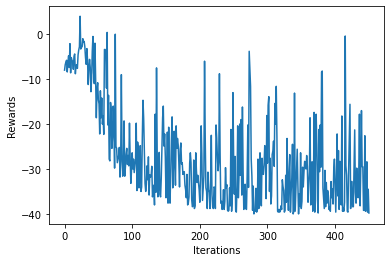

 45%|██████████████████████████████████▋                                          | 4512/10000 [09:49<12:53,  7.10it/s]

Mean Reward = -37.0
0


 45%|██████████████████████████████████▊                                          | 4521/10000 [09:50<12:58,  7.04it/s]

Mean Reward = -15.8
0


 45%|██████████████████████████████████▊                                          | 4526/10000 [09:51<16:49,  5.42it/s]

Updated Weights


 45%|██████████████████████████████████▉                                          | 4532/10000 [09:52<13:46,  6.62it/s]

Mean Reward = -36.8
0


 45%|██████████████████████████████████▉                                          | 4542/10000 [09:53<12:47,  7.11it/s]

Mean Reward = -39.4
0


 46%|███████████████████████████████████                                          | 4551/10000 [09:55<14:09,  6.41it/s]

Updated Weights
Mean Reward = -33.2
0


 46%|███████████████████████████████████▏                                         | 4562/10000 [09:56<13:16,  6.83it/s]

Mean Reward = -27.5
2


 46%|███████████████████████████████████▏                                         | 4572/10000 [09:58<14:19,  6.31it/s]

Mean Reward = -35.6
0


 46%|███████████████████████████████████▏                                         | 4577/10000 [09:58<14:08,  6.39it/s]

Updated Weights


 46%|███████████████████████████████████▎                                         | 4582/10000 [09:59<14:03,  6.42it/s]

Mean Reward = -21.9
1


 46%|███████████████████████████████████▎                                         | 4592/10000 [10:01<14:19,  6.29it/s]

Mean Reward = -38.4
0


 46%|███████████████████████████████████▍                                         | 4602/10000 [10:02<14:31,  6.19it/s]

Updated Weights
Mean Reward = -34.8
0


 46%|███████████████████████████████████▌                                         | 4612/10000 [10:04<15:53,  5.65it/s]

Mean Reward = -31.6
0


 46%|███████████████████████████████████▌                                         | 4622/10000 [10:05<12:21,  7.26it/s]

Mean Reward = -38.8
0


 46%|███████████████████████████████████▋                                         | 4627/10000 [10:06<12:34,  7.12it/s]

Updated Weights


 46%|███████████████████████████████████▋                                         | 4632/10000 [10:07<12:20,  7.24it/s]

Mean Reward = -37.4
0


 46%|███████████████████████████████████▋                                         | 4642/10000 [10:08<12:19,  7.24it/s]

Mean Reward = -37.4
0


 47%|███████████████████████████████████▊                                         | 4652/10000 [10:09<12:13,  7.29it/s]

Updated Weights
Mean Reward = -39.0
0


 47%|███████████████████████████████████▉                                         | 4662/10000 [10:11<12:30,  7.11it/s]

Mean Reward = -38.6
0


 47%|███████████████████████████████████▉                                         | 4672/10000 [10:12<14:03,  6.32it/s]

Mean Reward = -36.6
0


 47%|████████████████████████████████████                                         | 4677/10000 [10:13<13:59,  6.34it/s]

Updated Weights


 47%|████████████████████████████████████                                         | 4682/10000 [10:14<12:42,  6.97it/s]

Mean Reward = -39.2
0


 47%|████████████████████████████████████▏                                        | 4693/10000 [10:15<09:54,  8.93it/s]

Mean Reward = -37.2
0


 47%|████████████████████████████████████▏                                        | 4701/10000 [10:16<14:32,  6.07it/s]

Updated Weights
Mean Reward = -34.5
1


 47%|████████████████████████████████████▎                                        | 4712/10000 [10:18<12:34,  7.00it/s]

Mean Reward = -33.8
0


 47%|████████████████████████████████████▎                                        | 4722/10000 [10:19<11:52,  7.41it/s]

Mean Reward = -39.4
0


 47%|████████████████████████████████████▍                                        | 4727/10000 [10:20<11:31,  7.63it/s]

Updated Weights


 47%|████████████████████████████████████▍                                        | 4732/10000 [10:21<11:54,  7.38it/s]

Mean Reward = -36.0
0


 47%|████████████████████████████████████▌                                        | 4742/10000 [10:22<12:38,  6.93it/s]

Mean Reward = -38.0
0


 48%|████████████████████████████████████▌                                        | 4752/10000 [10:24<12:47,  6.84it/s]

Updated Weights
Mean Reward = -38.8
0


 48%|████████████████████████████████████▋                                        | 4762/10000 [10:25<12:48,  6.82it/s]

Mean Reward = -38.4
0


 48%|████████████████████████████████████▋                                        | 4772/10000 [10:27<12:12,  7.14it/s]

Mean Reward = -37.0
0


 48%|████████████████████████████████████▊                                        | 4777/10000 [10:27<12:20,  7.06it/s]

Updated Weights


 48%|████████████████████████████████████▊                                        | 4782/10000 [10:28<12:35,  6.91it/s]

Mean Reward = -36.4
0


 48%|████████████████████████████████████▉                                        | 4793/10000 [10:30<11:08,  7.79it/s]

Mean Reward = -36.8
0


 48%|████████████████████████████████████▉                                        | 4802/10000 [10:31<15:17,  5.66it/s]

Updated Weights
Mean Reward = -33.4
1


 48%|█████████████████████████████████████                                        | 4812/10000 [10:33<13:40,  6.32it/s]

Mean Reward = -37.0
0


 48%|█████████████████████████████████████                                        | 4821/10000 [10:35<16:53,  5.11it/s]

Mean Reward = -37.0
0


 48%|█████████████████████████████████████▏                                       | 4827/10000 [10:36<14:08,  6.10it/s]

Updated Weights


 48%|█████████████████████████████████████▏                                       | 4831/10000 [10:36<15:39,  5.50it/s]

Mean Reward = -36.4
0


 48%|█████████████████████████████████████▎                                       | 4842/10000 [10:38<13:24,  6.41it/s]

Mean Reward = -32.6
1


 49%|█████████████████████████████████████▎                                       | 4852/10000 [10:39<12:09,  7.05it/s]

Updated Weights
Mean Reward = -31.7
1


 49%|█████████████████████████████████████▍                                       | 4862/10000 [10:41<12:32,  6.83it/s]

Mean Reward = -36.8
0


 49%|█████████████████████████████████████▌                                       | 4872/10000 [10:42<11:44,  7.28it/s]

Mean Reward = -38.2
0


 49%|█████████████████████████████████████▌                                       | 4877/10000 [10:43<11:58,  7.13it/s]

Updated Weights


 49%|█████████████████████████████████████▌                                       | 4882/10000 [10:44<12:12,  6.99it/s]

Mean Reward = -39.2
0


 49%|█████████████████████████████████████▋                                       | 4892/10000 [10:45<11:45,  7.24it/s]

Mean Reward = -37.8
0


 49%|█████████████████████████████████████▋                                       | 4902/10000 [10:46<11:39,  7.29it/s]

Updated Weights
Mean Reward = -32.5
1


 49%|█████████████████████████████████████▊                                       | 4912/10000 [10:48<09:27,  8.96it/s]

Mean Reward = -26.7
2


 49%|█████████████████████████████████████▉                                       | 4922/10000 [10:49<10:35,  7.99it/s]

Mean Reward = -26.7
2


 49%|█████████████████████████████████████▉                                       | 4927/10000 [10:50<11:54,  7.10it/s]

Updated Weights


 49%|█████████████████████████████████████▉                                       | 4932/10000 [10:50<12:03,  7.00it/s]

Mean Reward = -38.8
0


 49%|██████████████████████████████████████                                       | 4942/10000 [10:52<12:20,  6.83it/s]

Mean Reward = -36.2
0


 50%|██████████████████████████████████████▏                                      | 4952/10000 [10:53<12:18,  6.83it/s]

Updated Weights
Mean Reward = -38.6
0


 50%|██████████████████████████████████████▏                                      | 4962/10000 [10:55<11:46,  7.13it/s]

Mean Reward = -38.0
0


 50%|██████████████████████████████████████▎                                      | 4972/10000 [10:56<11:56,  7.02it/s]

Mean Reward = -37.6
0


 50%|██████████████████████████████████████▎                                      | 4977/10000 [10:57<11:55,  7.02it/s]

Updated Weights


 50%|██████████████████████████████████████▎                                      | 4982/10000 [10:57<11:55,  7.02it/s]

Mean Reward = -39.4
0


 50%|██████████████████████████████████████▍                                      | 4992/10000 [10:59<11:38,  7.17it/s]

Mean Reward = -32.4
1


 50%|██████████████████████████████████████▌                                      | 5000/10000 [11:00<12:00,  6.94it/s]

Updated Weights
Mean Reward = -36.4
0


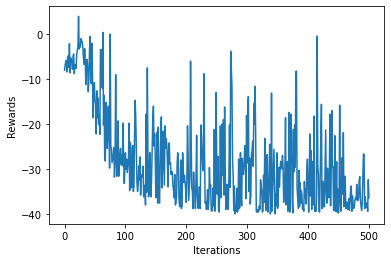

 50%|██████████████████████████████████████▌                                      | 5012/10000 [11:02<11:56,  6.96it/s]

Mean Reward = -35.4
0


 50%|██████████████████████████████████████▋                                      | 5022/10000 [11:03<12:01,  6.90it/s]

Mean Reward = -36.2
0


 50%|██████████████████████████████████████▋                                      | 5027/10000 [11:04<12:02,  6.89it/s]

Updated Weights


 50%|██████████████████████████████████████▋                                      | 5032/10000 [11:05<11:29,  7.21it/s]

Mean Reward = -36.4
0


 50%|██████████████████████████████████████▊                                      | 5042/10000 [11:06<11:32,  7.16it/s]

Mean Reward = -38.2
0


 51%|██████████████████████████████████████▉                                      | 5052/10000 [11:07<11:42,  7.04it/s]

Updated Weights
Mean Reward = -37.8
0


 51%|██████████████████████████████████████▉                                      | 5062/10000 [11:09<11:42,  7.03it/s]

Mean Reward = -39.2
0


 51%|███████████████████████████████████████                                      | 5072/10000 [11:10<11:23,  7.21it/s]

Mean Reward = -34.0
1


 51%|███████████████████████████████████████                                      | 5077/10000 [11:11<11:58,  6.85it/s]

Updated Weights


 51%|███████████████████████████████████████                                      | 5081/10000 [11:12<15:43,  5.21it/s]

Mean Reward = -39.2
0


 51%|███████████████████████████████████████▏                                     | 5091/10000 [11:14<14:44,  5.55it/s]

Mean Reward = -37.6
0


 51%|███████████████████████████████████████▎                                     | 5102/10000 [11:15<13:09,  6.20it/s]

Updated Weights
Mean Reward = -39.4
0


 51%|███████████████████████████████████████▎                                     | 5111/10000 [11:17<15:16,  5.33it/s]

Mean Reward = -39.2
0


 51%|███████████████████████████████████████▍                                     | 5122/10000 [11:19<13:03,  6.23it/s]

Mean Reward = -38.8
0


 51%|███████████████████████████████████████▍                                     | 5127/10000 [11:20<12:45,  6.37it/s]

Updated Weights


 51%|███████████████████████████████████████▌                                     | 5132/10000 [11:20<13:13,  6.13it/s]

Mean Reward = -35.0
0


 51%|███████████████████████████████████████▌                                     | 5141/10000 [11:22<18:06,  4.47it/s]

Mean Reward = -34.2
0


 52%|███████████████████████████████████████▋                                     | 5151/10000 [11:24<16:33,  4.88it/s]

Updated Weights
Mean Reward = -39.6
0


 52%|███████████████████████████████████████▋                                     | 5161/10000 [11:26<13:03,  6.18it/s]

Mean Reward = -31.8
0


 52%|███████████████████████████████████████▊                                     | 5171/10000 [11:28<16:38,  4.84it/s]

Mean Reward = -38.4
0


 52%|███████████████████████████████████████▊                                     | 5177/10000 [11:29<13:46,  5.83it/s]

Updated Weights


 52%|███████████████████████████████████████▉                                     | 5182/10000 [11:30<13:22,  6.00it/s]

Mean Reward = -34.2
0


 52%|███████████████████████████████████████▉                                     | 5192/10000 [11:32<12:52,  6.22it/s]

Mean Reward = -33.2
1


 52%|████████████████████████████████████████                                     | 5202/10000 [11:33<13:01,  6.14it/s]

Updated Weights
Mean Reward = -39.0
0


 52%|████████████████████████████████████████                                     | 5211/10000 [11:35<14:53,  5.36it/s]

Mean Reward = -38.4
0


 52%|████████████████████████████████████████▏                                    | 5221/10000 [11:37<16:01,  4.97it/s]

Mean Reward = -25.6
0


 52%|████████████████████████████████████████▏                                    | 5226/10000 [11:38<15:48,  5.04it/s]

Updated Weights


 52%|████████████████████████████████████████▎                                    | 5231/10000 [11:39<17:24,  4.56it/s]

Mean Reward = -35.4
0


 52%|████████████████████████████████████████▎                                    | 5241/10000 [11:41<16:20,  4.85it/s]

Mean Reward = -37.0
0


 53%|████████████████████████████████████████▍                                    | 5252/10000 [11:43<12:16,  6.45it/s]

Updated Weights
Mean Reward = -39.6
0


 53%|████████████████████████████████████████▌                                    | 5261/10000 [11:44<14:21,  5.50it/s]

Mean Reward = -22.2
0


 53%|████████████████████████████████████████▌                                    | 5272/10000 [11:46<13:31,  5.82it/s]

Mean Reward = -32.0
0


 53%|████████████████████████████████████████▋                                    | 5276/10000 [11:47<14:01,  5.62it/s]

Updated Weights


 53%|████████████████████████████████████████▋                                    | 5282/10000 [11:48<13:10,  5.97it/s]

Mean Reward = -38.8
0


 53%|████████████████████████████████████████▋                                    | 5292/10000 [11:50<12:02,  6.51it/s]

Mean Reward = -34.1
1


 53%|████████████████████████████████████████▊                                    | 5301/10000 [11:51<16:52,  4.64it/s]

Updated Weights
Mean Reward = -39.2
0


 53%|████████████████████████████████████████▉                                    | 5311/10000 [11:54<14:10,  5.52it/s]

Mean Reward = -39.6
0


 53%|████████████████████████████████████████▉                                    | 5322/10000 [11:55<12:22,  6.30it/s]

Mean Reward = -35.2
0


 53%|█████████████████████████████████████████                                    | 5327/10000 [11:56<12:21,  6.31it/s]

Updated Weights


 53%|█████████████████████████████████████████                                    | 5332/10000 [11:57<12:35,  6.18it/s]

Mean Reward = -35.0
0


 53%|█████████████████████████████████████████▏                                   | 5342/10000 [11:59<13:50,  5.61it/s]

Mean Reward = -39.8
0


 54%|█████████████████████████████████████████▏                                   | 5352/10000 [12:00<12:09,  6.37it/s]

Updated Weights
Mean Reward = -36.0
0


 54%|█████████████████████████████████████████▎                                   | 5361/10000 [12:02<17:07,  4.52it/s]

Mean Reward = -38.8
0


 54%|█████████████████████████████████████████▎                                   | 5372/10000 [12:05<13:28,  5.72it/s]

Mean Reward = -27.0
0


 54%|█████████████████████████████████████████▍                                   | 5376/10000 [12:05<14:57,  5.15it/s]

Updated Weights


 54%|█████████████████████████████████████████▍                                   | 5381/10000 [12:06<15:55,  4.83it/s]

Mean Reward = -30.8
0


 54%|█████████████████████████████████████████▌                                   | 5391/10000 [12:09<17:17,  4.44it/s]

Mean Reward = -38.2
0


 54%|█████████████████████████████████████████▌                                   | 5401/10000 [12:11<15:05,  5.08it/s]

Updated Weights
Mean Reward = -38.6
0


 54%|█████████████████████████████████████████▋                                   | 5412/10000 [12:12<12:36,  6.06it/s]

Mean Reward = -39.8
0


 54%|█████████████████████████████████████████▋                                   | 5422/10000 [12:14<13:50,  5.51it/s]

Mean Reward = -39.8
0


 54%|█████████████████████████████████████████▊                                   | 5426/10000 [12:15<14:31,  5.25it/s]

Updated Weights


 54%|█████████████████████████████████████████▊                                   | 5431/10000 [12:16<14:59,  5.08it/s]

Mean Reward = -39.4
0


 54%|█████████████████████████████████████████▉                                   | 5441/10000 [12:18<15:24,  4.93it/s]

Mean Reward = -39.0
0


 55%|█████████████████████████████████████████▉                                   | 5452/10000 [12:20<13:27,  5.63it/s]

Updated Weights
Mean Reward = -40.0
0


 55%|██████████████████████████████████████████                                   | 5462/10000 [12:22<13:07,  5.76it/s]

Mean Reward = -39.8
0


 55%|██████████████████████████████████████████▏                                  | 5471/10000 [12:24<15:01,  5.03it/s]

Mean Reward = -34.4
0


 55%|██████████████████████████████████████████▏                                  | 5476/10000 [12:25<14:39,  5.15it/s]

Updated Weights


 55%|██████████████████████████████████████████▏                                  | 5482/10000 [12:26<12:40,  5.94it/s]

Mean Reward = -38.0
0


 55%|██████████████████████████████████████████▎                                  | 5491/10000 [12:27<14:51,  5.06it/s]

Mean Reward = -39.8
0


 55%|██████████████████████████████████████████▎                                  | 5500/10000 [12:29<13:42,  5.47it/s]

Updated Weights
Mean Reward = -35.0
0


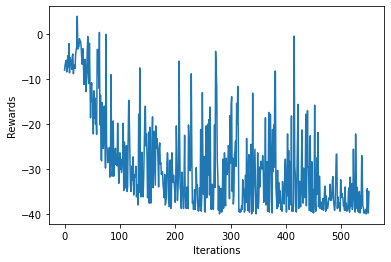

 55%|██████████████████████████████████████████▍                                  | 5512/10000 [12:31<11:39,  6.41it/s]

Mean Reward = -31.2
0


 55%|██████████████████████████████████████████▌                                  | 5522/10000 [12:33<12:36,  5.92it/s]

Mean Reward = -36.4
0


 55%|██████████████████████████████████████████▌                                  | 5526/10000 [12:34<15:59,  4.66it/s]

Updated Weights


 55%|██████████████████████████████████████████▌                                  | 5531/10000 [12:35<15:14,  4.89it/s]

Mean Reward = -35.4
0


 55%|██████████████████████████████████████████▋                                  | 5541/10000 [12:37<15:46,  4.71it/s]

Mean Reward = -35.2
0


 56%|██████████████████████████████████████████▋                                  | 5551/10000 [12:39<17:25,  4.26it/s]

Updated Weights
Mean Reward = -37.8
0


 56%|██████████████████████████████████████████▊                                  | 5561/10000 [12:41<16:17,  4.54it/s]

Mean Reward = -33.4
0


 56%|██████████████████████████████████████████▉                                  | 5572/10000 [12:43<11:12,  6.58it/s]

Mean Reward = -39.6
0


 56%|██████████████████████████████████████████▉                                  | 5577/10000 [12:44<11:26,  6.44it/s]

Updated Weights


 56%|██████████████████████████████████████████▉                                  | 5582/10000 [12:45<11:35,  6.35it/s]

Mean Reward = -38.8
0


 56%|███████████████████████████████████████████                                  | 5592/10000 [12:46<11:37,  6.32it/s]

Mean Reward = -32.2
0


 56%|███████████████████████████████████████████▏                                 | 5601/10000 [12:48<12:43,  5.76it/s]

Updated Weights
Mean Reward = -30.2
0


 56%|███████████████████████████████████████████▏                                 | 5611/10000 [12:50<12:53,  5.67it/s]

Mean Reward = -36.4
0


 56%|███████████████████████████████████████████▎                                 | 5621/10000 [12:51<12:58,  5.62it/s]

Mean Reward = -34.8
0


 56%|███████████████████████████████████████████▎                                 | 5626/10000 [12:52<15:37,  4.67it/s]

Updated Weights


 56%|███████████████████████████████████████████▎                                 | 5631/10000 [12:53<13:58,  5.21it/s]

Mean Reward = -39.2
0


 56%|███████████████████████████████████████████▍                                 | 5642/10000 [12:55<13:12,  5.50it/s]

Mean Reward = -38.0
0


 57%|███████████████████████████████████████████▌                                 | 5651/10000 [12:57<12:33,  5.77it/s]

Updated Weights
Mean Reward = -38.4
0


 57%|███████████████████████████████████████████▌                                 | 5662/10000 [12:59<11:04,  6.53it/s]

Mean Reward = -34.8
0


 57%|███████████████████████████████████████████▋                                 | 5671/10000 [13:00<10:41,  6.74it/s]

Mean Reward = -38.6
0


 57%|███████████████████████████████████████████▋                                 | 5677/10000 [13:01<11:15,  6.40it/s]

Updated Weights


 57%|███████████████████████████████████████████▋                                 | 5681/10000 [13:02<12:31,  5.75it/s]

Mean Reward = -38.2
0


 57%|███████████████████████████████████████████▊                                 | 5691/10000 [13:04<15:08,  4.74it/s]

Mean Reward = -36.6
0


 57%|███████████████████████████████████████████▉                                 | 5702/10000 [13:06<11:15,  6.36it/s]

Updated Weights
Mean Reward = -31.8
0


 57%|███████████████████████████████████████████▉                                 | 5712/10000 [13:07<10:44,  6.66it/s]

Mean Reward = -35.6
0


 57%|████████████████████████████████████████████                                 | 5722/10000 [13:09<11:16,  6.33it/s]

Mean Reward = -35.6
0


 57%|████████████████████████████████████████████                                 | 5727/10000 [13:10<12:09,  5.86it/s]

Updated Weights


 57%|████████████████████████████████████████████▏                                | 5732/10000 [13:10<10:52,  6.54it/s]

Mean Reward = -39.6
0


 57%|████████████████████████████████████████████▏                                | 5742/10000 [13:12<11:01,  6.44it/s]

Mean Reward = -30.2
0


 58%|████████████████████████████████████████████▎                                | 5752/10000 [13:13<10:53,  6.50it/s]

Updated Weights
Mean Reward = -35.2
0


 58%|████████████████████████████████████████████▎                                | 5762/10000 [13:15<09:47,  7.22it/s]

Mean Reward = -39.4
0


 58%|████████████████████████████████████████████▍                                | 5772/10000 [13:16<09:56,  7.09it/s]

Mean Reward = -39.2
0


 58%|████████████████████████████████████████████▍                                | 5777/10000 [13:17<10:55,  6.44it/s]

Updated Weights


 58%|████████████████████████████████████████████▌                                | 5782/10000 [13:18<10:06,  6.95it/s]

Mean Reward = -38.8
0


 58%|████████████████████████████████████████████▌                                | 5792/10000 [13:19<09:48,  7.14it/s]

Mean Reward = -26.2
1


 58%|████████████████████████████████████████████▋                                | 5802/10000 [13:20<09:55,  7.05it/s]

Updated Weights
Mean Reward = -33.4
0


 58%|████████████████████████████████████████████▊                                | 5812/10000 [13:22<10:00,  6.98it/s]

Mean Reward = -31.8
0


 58%|████████████████████████████████████████████▊                                | 5822/10000 [13:23<10:20,  6.74it/s]

Mean Reward = -25.2
0


 58%|████████████████████████████████████████████▊                                | 5827/10000 [13:24<10:07,  6.87it/s]

Updated Weights


 58%|████████████████████████████████████████████▉                                | 5832/10000 [13:25<11:28,  6.05it/s]

Mean Reward = -37.8
0


 58%|████████████████████████████████████████████▉                                | 5842/10000 [13:26<09:50,  7.04it/s]

Mean Reward = -34.8
0


 59%|█████████████████████████████████████████████                                | 5852/10000 [13:28<10:49,  6.39it/s]

Updated Weights
Mean Reward = -39.2
0


 59%|█████████████████████████████████████████████▏                               | 5862/10000 [13:29<10:44,  6.42it/s]

Mean Reward = -40.0
0


 59%|█████████████████████████████████████████████▏                               | 5872/10000 [13:31<09:52,  6.97it/s]

Mean Reward = -40.0
0


 59%|█████████████████████████████████████████████▎                               | 5877/10000 [13:32<09:54,  6.94it/s]

Updated Weights


 59%|█████████████████████████████████████████████▎                               | 5882/10000 [13:32<09:43,  7.06it/s]

Mean Reward = -36.8
0


 59%|█████████████████████████████████████████████▎                               | 5892/10000 [13:34<09:41,  7.07it/s]

Mean Reward = -37.2
0


 59%|█████████████████████████████████████████████▍                               | 5902/10000 [13:35<09:40,  7.06it/s]

Updated Weights
Mean Reward = -38.4
0


 59%|█████████████████████████████████████████████▌                               | 5912/10000 [13:37<09:34,  7.11it/s]

Mean Reward = -39.2
0


 59%|█████████████████████████████████████████████▌                               | 5922/10000 [13:38<09:35,  7.09it/s]

Mean Reward = -38.6
0


 59%|█████████████████████████████████████████████▋                               | 5927/10000 [13:39<09:32,  7.11it/s]

Updated Weights


 59%|█████████████████████████████████████████████▋                               | 5932/10000 [13:40<09:40,  7.01it/s]

Mean Reward = -36.4
0


 59%|█████████████████████████████████████████████▊                               | 5942/10000 [13:41<10:47,  6.27it/s]

Mean Reward = -38.4
0


 60%|█████████████████████████████████████████████▊                               | 5952/10000 [13:43<09:45,  6.92it/s]

Updated Weights
Mean Reward = -33.7
1


 60%|█████████████████████████████████████████████▉                               | 5961/10000 [13:44<10:16,  6.56it/s]

Mean Reward = -38.8
0


 60%|█████████████████████████████████████████████▉                               | 5971/10000 [13:46<11:24,  5.88it/s]

Mean Reward = -38.4
0


 60%|██████████████████████████████████████████████                               | 5977/10000 [13:47<10:00,  6.70it/s]

Updated Weights


 60%|██████████████████████████████████████████████                               | 5982/10000 [13:48<12:26,  5.38it/s]

Mean Reward = -34.9
1


 60%|██████████████████████████████████████████████▏                              | 5991/10000 [13:49<12:18,  5.43it/s]

Mean Reward = -34.0
0


 60%|██████████████████████████████████████████████▏                              | 6000/10000 [13:51<13:09,  5.07it/s]

Updated Weights
Mean Reward = -39.4
0


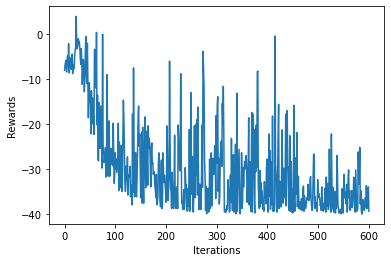

 60%|██████████████████████████████████████████████▎                              | 6011/10000 [13:53<11:15,  5.90it/s]

Mean Reward = -32.3
1


 60%|██████████████████████████████████████████████▎                              | 6021/10000 [13:55<14:08,  4.69it/s]

Mean Reward = -39.8
0


 60%|██████████████████████████████████████████████▍                              | 6027/10000 [13:56<10:48,  6.13it/s]

Updated Weights


 60%|██████████████████████████████████████████████▍                              | 6032/10000 [13:57<11:47,  5.61it/s]

Mean Reward = -32.5
1


 60%|██████████████████████████████████████████████▌                              | 6041/10000 [13:59<14:14,  4.63it/s]

Mean Reward = -34.8
0


 61%|██████████████████████████████████████████████▌                              | 6051/10000 [14:01<17:49,  3.69it/s]

Updated Weights
Mean Reward = -40.0
0


 61%|██████████████████████████████████████████████▋                              | 6062/10000 [14:04<13:13,  4.96it/s]

Mean Reward = -34.7
1


 61%|██████████████████████████████████████████████▊                              | 6072/10000 [14:05<10:53,  6.01it/s]

Mean Reward = -40.0
0


 61%|██████████████████████████████████████████████▊                              | 6077/10000 [14:06<11:01,  5.93it/s]

Updated Weights


 61%|██████████████████████████████████████████████▊                              | 6081/10000 [14:07<11:21,  5.75it/s]

Mean Reward = -33.4
1


 61%|██████████████████████████████████████████████▉                              | 6092/10000 [14:09<10:52,  5.99it/s]

Mean Reward = -37.6
0


 61%|██████████████████████████████████████████████▉                              | 6102/10000 [14:10<09:48,  6.62it/s]

Updated Weights
Mean Reward = -33.8
0


 61%|███████████████████████████████████████████████                              | 6111/10000 [14:12<12:18,  5.27it/s]

Mean Reward = -35.4
0


 61%|███████████████████████████████████████████████▏                             | 6122/10000 [14:14<12:15,  5.27it/s]

Mean Reward = -36.4
0


 61%|███████████████████████████████████████████████▏                             | 6127/10000 [14:15<11:02,  5.84it/s]

Updated Weights


 61%|███████████████████████████████████████████████▏                             | 6132/10000 [14:16<10:38,  6.06it/s]

Mean Reward = -39.8
0


 61%|███████████████████████████████████████████████▎                             | 6141/10000 [14:18<14:26,  4.45it/s]

Mean Reward = -38.6
0


 62%|███████████████████████████████████████████████▎                             | 6151/10000 [14:20<10:59,  5.84it/s]

Updated Weights
Mean Reward = -34.0
0


 62%|███████████████████████████████████████████████▍                             | 6162/10000 [14:21<11:18,  5.66it/s]

Mean Reward = -32.5
1


 62%|███████████████████████████████████████████████▌                             | 6172/10000 [14:23<11:09,  5.72it/s]

Mean Reward = -39.4
0


 62%|███████████████████████████████████████████████▌                             | 6177/10000 [14:24<10:42,  5.95it/s]

Updated Weights


 62%|███████████████████████████████████████████████▌                             | 6181/10000 [14:25<10:43,  5.93it/s]

Mean Reward = -36.0
0


 62%|███████████████████████████████████████████████▋                             | 6191/10000 [14:27<13:16,  4.78it/s]

Mean Reward = -39.2
0


 62%|███████████████████████████████████████████████▋                             | 6201/10000 [14:29<13:01,  4.86it/s]

Updated Weights
Mean Reward = -34.4
1


 62%|███████████████████████████████████████████████▊                             | 6210/10000 [14:30<12:53,  4.90it/s]

Mean Reward = -30.8
1


 62%|███████████████████████████████████████████████▉                             | 6222/10000 [14:32<09:52,  6.37it/s]

Mean Reward = -38.4
0


 62%|███████████████████████████████████████████████▉                             | 6227/10000 [14:33<09:30,  6.62it/s]

Updated Weights


 62%|███████████████████████████████████████████████▉                             | 6232/10000 [14:34<09:34,  6.56it/s]

Mean Reward = -33.4
1


 62%|████████████████████████████████████████████████                             | 6242/10000 [14:35<09:28,  6.61it/s]

Mean Reward = -39.8
0


 63%|████████████████████████████████████████████████▏                            | 6252/10000 [14:37<09:57,  6.28it/s]

Updated Weights
Mean Reward = -38.2
0


 63%|████████████████████████████████████████████████▏                            | 6262/10000 [14:38<09:31,  6.54it/s]

Mean Reward = -39.0
0


 63%|████████████████████████████████████████████████▎                            | 6272/10000 [14:40<09:42,  6.40it/s]

Mean Reward = -35.4
0


 63%|████████████████████████████████████████████████▎                            | 6277/10000 [14:41<09:28,  6.54it/s]

Updated Weights


 63%|████████████████████████████████████████████████▎                            | 6282/10000 [14:41<09:17,  6.67it/s]

Mean Reward = -39.4
0


 63%|████████████████████████████████████████████████▍                            | 6292/10000 [14:43<09:25,  6.56it/s]

Mean Reward = -39.0
0


 63%|████████████████████████████████████████████████▌                            | 6302/10000 [14:45<09:23,  6.56it/s]

Updated Weights
Mean Reward = -39.6
0


 63%|████████████████████████████████████████████████▌                            | 6312/10000 [14:46<09:10,  6.70it/s]

Mean Reward = -38.8
0


 63%|████████████████████████████████████████████████▋                            | 6322/10000 [14:47<08:57,  6.84it/s]

Mean Reward = -33.5
1


 63%|████████████████████████████████████████████████▋                            | 6327/10000 [14:48<09:06,  6.73it/s]

Updated Weights


 63%|████████████████████████████████████████████████▊                            | 6332/10000 [14:49<08:57,  6.82it/s]

Mean Reward = -36.6
0


 63%|████████████████████████████████████████████████▊                            | 6342/10000 [14:50<08:53,  6.85it/s]

Mean Reward = -33.9
1


 64%|████████████████████████████████████████████████▉                            | 6352/10000 [14:52<09:55,  6.12it/s]

Updated Weights
Mean Reward = -38.6
0


 64%|████████████████████████████████████████████████▉                            | 6361/10000 [14:53<09:17,  6.53it/s]

Mean Reward = -34.2
1


 64%|█████████████████████████████████████████████████                            | 6371/10000 [14:55<09:38,  6.28it/s]

Mean Reward = -38.8
0


 64%|█████████████████████████████████████████████████                            | 6376/10000 [14:56<09:25,  6.41it/s]

Updated Weights


 64%|█████████████████████████████████████████████████▏                           | 6381/10000 [14:56<10:34,  5.71it/s]

Mean Reward = -38.6
0


 64%|█████████████████████████████████████████████████▏                           | 6391/10000 [14:58<11:15,  5.35it/s]

Mean Reward = -39.2
0


 64%|█████████████████████████████████████████████████▎                           | 6402/10000 [15:00<08:51,  6.77it/s]

Updated Weights
Mean Reward = -39.0
0


 64%|█████████████████████████████████████████████████▎                           | 6412/10000 [15:02<08:48,  6.78it/s]

Mean Reward = -37.8
0


 64%|█████████████████████████████████████████████████▍                           | 6422/10000 [15:03<08:09,  7.31it/s]

Mean Reward = -30.1
1


 64%|█████████████████████████████████████████████████▍                           | 6427/10000 [15:04<08:41,  6.85it/s]

Updated Weights


 64%|█████████████████████████████████████████████████▌                           | 6432/10000 [15:04<09:03,  6.57it/s]

Mean Reward = -39.4
0


 64%|█████████████████████████████████████████████████▌                           | 6442/10000 [15:06<08:26,  7.03it/s]

Mean Reward = -39.4
0


 65%|█████████████████████████████████████████████████▋                           | 6452/10000 [15:07<08:44,  6.77it/s]

Updated Weights
Mean Reward = -39.0
0


 65%|█████████████████████████████████████████████████▊                           | 6462/10000 [15:09<08:27,  6.97it/s]

Mean Reward = -39.0
0


 65%|█████████████████████████████████████████████████▊                           | 6472/10000 [15:10<08:41,  6.77it/s]

Mean Reward = -39.6
0


 65%|█████████████████████████████████████████████████▊                           | 6477/10000 [15:11<08:39,  6.78it/s]

Updated Weights


 65%|█████████████████████████████████████████████████▉                           | 6482/10000 [15:12<07:56,  7.38it/s]

Mean Reward = -32.7
1


 65%|█████████████████████████████████████████████████▉                           | 6491/10000 [15:13<08:26,  6.93it/s]

Mean Reward = -38.6
0


 65%|██████████████████████████████████████████████████                           | 6500/10000 [15:14<08:06,  7.20it/s]

Updated Weights
Mean Reward = -37.8
0


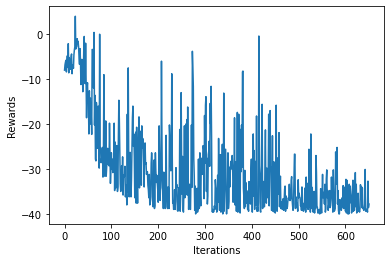

 65%|██████████████████████████████████████████████████▏                          | 6512/10000 [15:16<07:48,  7.44it/s]

Mean Reward = -39.4
0


 65%|██████████████████████████████████████████████████▏                          | 6522/10000 [15:18<07:58,  7.27it/s]

Mean Reward = -36.8
0


 65%|██████████████████████████████████████████████████▎                          | 6527/10000 [15:19<08:33,  6.76it/s]

Updated Weights


 65%|██████████████████████████████████████████████████▎                          | 6531/10000 [15:19<08:15,  6.99it/s]

Mean Reward = -38.0
0


 65%|██████████████████████████████████████████████████▎                          | 6542/10000 [15:21<07:39,  7.52it/s]

Mean Reward = -36.4
0


 66%|██████████████████████████████████████████████████▍                          | 6552/10000 [15:22<07:39,  7.51it/s]

Updated Weights
Mean Reward = -38.2
0


 66%|██████████████████████████████████████████████████▌                          | 6562/10000 [15:23<08:28,  6.76it/s]

Mean Reward = -39.6
0


 66%|██████████████████████████████████████████████████▌                          | 6572/10000 [15:25<07:53,  7.24it/s]

Mean Reward = -34.1
1


 66%|██████████████████████████████████████████████████▋                          | 6577/10000 [15:25<08:02,  7.10it/s]

Updated Weights


 66%|██████████████████████████████████████████████████▋                          | 6581/10000 [15:26<10:17,  5.54it/s]

Mean Reward = -39.0
0


 66%|██████████████████████████████████████████████████▊                          | 6592/10000 [15:28<08:38,  6.58it/s]

Mean Reward = -38.6
0


 66%|██████████████████████████████████████████████████▊                          | 6601/10000 [15:29<09:58,  5.68it/s]

Updated Weights
Mean Reward = -38.2
0


 66%|██████████████████████████████████████████████████▉                          | 6611/10000 [15:31<10:37,  5.32it/s]

Mean Reward = -39.6
0


 66%|██████████████████████████████████████████████████▉                          | 6622/10000 [15:34<10:30,  5.36it/s]

Mean Reward = -35.6
0


 66%|███████████████████████████████████████████████████                          | 6627/10000 [15:34<09:14,  6.08it/s]

Updated Weights


 66%|███████████████████████████████████████████████████                          | 6632/10000 [15:35<07:56,  7.07it/s]

Mean Reward = -38.6
0


 66%|███████████████████████████████████████████████████▏                         | 6642/10000 [15:36<07:25,  7.54it/s]

Mean Reward = -38.4
0


 67%|███████████████████████████████████████████████████▏                         | 6652/10000 [15:38<07:55,  7.03it/s]

Updated Weights
Mean Reward = -39.8
0


 67%|███████████████████████████████████████████████████▎                         | 6662/10000 [15:39<07:18,  7.61it/s]

Mean Reward = -36.0
0


 67%|███████████████████████████████████████████████████▎                         | 6672/10000 [15:40<05:53,  9.42it/s]

Mean Reward = -39.0
0


 67%|███████████████████████████████████████████████████▍                         | 6679/10000 [15:41<04:54, 11.27it/s]

Updated Weights


 67%|███████████████████████████████████████████████████▍                         | 6683/10000 [15:41<05:11, 10.65it/s]

Mean Reward = -28.6
2


 67%|███████████████████████████████████████████████████▌                         | 6693/10000 [15:42<05:16, 10.45it/s]

Mean Reward = -39.2
0


 67%|███████████████████████████████████████████████████▌                         | 6703/10000 [15:43<05:06, 10.75it/s]

Updated Weights
Mean Reward = -35.0
0


 67%|███████████████████████████████████████████████████▋                         | 6711/10000 [15:44<05:12, 10.51it/s]

Mean Reward = -39.0
0


 67%|███████████████████████████████████████████████████▊                         | 6723/10000 [15:45<05:53,  9.28it/s]

Mean Reward = -37.4
0


 67%|███████████████████████████████████████████████████▊                         | 6728/10000 [15:46<05:43,  9.52it/s]

Updated Weights


 67%|███████████████████████████████████████████████████▊                         | 6733/10000 [15:46<06:05,  8.95it/s]

Mean Reward = -34.3
1


 67%|███████████████████████████████████████████████████▉                         | 6742/10000 [15:47<05:27,  9.95it/s]

Mean Reward = -40.0
0


 68%|███████████████████████████████████████████████████▉                         | 6753/10000 [15:48<05:24, 10.00it/s]

Updated Weights
Mean Reward = -38.8
0


 68%|████████████████████████████████████████████████████                         | 6762/10000 [15:49<05:36,  9.61it/s]

Mean Reward = -39.4
0


 68%|████████████████████████████████████████████████████▏                        | 6772/10000 [15:50<05:18, 10.14it/s]

Mean Reward = -39.8
0


 68%|████████████████████████████████████████████████████▏                        | 6777/10000 [15:51<05:33,  9.67it/s]

Updated Weights


 68%|████████████████████████████████████████████████████▏                        | 6783/10000 [15:51<05:46,  9.28it/s]

Mean Reward = -39.6
0


 68%|████████████████████████████████████████████████████▎                        | 6792/10000 [15:52<05:22,  9.95it/s]

Mean Reward = -38.4
0


 68%|████████████████████████████████████████████████████▍                        | 6803/10000 [15:53<05:21,  9.95it/s]

Updated Weights
Mean Reward = -38.4
0


 68%|████████████████████████████████████████████████████▍                        | 6813/10000 [15:55<05:30,  9.66it/s]

Mean Reward = -39.0
0


 68%|████████████████████████████████████████████████████▌                        | 6822/10000 [15:55<05:26,  9.72it/s]

Mean Reward = -38.6
0


 68%|████████████████████████████████████████████████████▌                        | 6826/10000 [15:56<05:13, 10.12it/s]

Updated Weights


 68%|████████████████████████████████████████████████████▌                        | 6832/10000 [15:56<05:32,  9.54it/s]

Mean Reward = -38.8
0


 68%|████████████████████████████████████████████████████▋                        | 6842/10000 [15:57<05:23,  9.76it/s]

Mean Reward = -39.4
0


 69%|████████████████████████████████████████████████████▊                        | 6852/10000 [15:58<05:07, 10.23it/s]

Updated Weights
Mean Reward = -38.6
0


 69%|████████████████████████████████████████████████████▊                        | 6863/10000 [15:59<04:28, 11.70it/s]

Mean Reward = -28.8
2


 69%|████████████████████████████████████████████████████▉                        | 6871/10000 [16:00<05:14,  9.94it/s]

Mean Reward = -39.0
0


 69%|████████████████████████████████████████████████████▉                        | 6877/10000 [16:01<05:41,  9.14it/s]

Updated Weights


 69%|████████████████████████████████████████████████████▉                        | 6882/10000 [16:02<06:12,  8.38it/s]

Mean Reward = -38.2
0


 69%|█████████████████████████████████████████████████████                        | 6892/10000 [16:03<06:26,  8.04it/s]

Mean Reward = -38.8
0


 69%|█████████████████████████████████████████████████████▏                       | 6902/10000 [16:04<06:28,  7.97it/s]

Updated Weights
Mean Reward = -37.0
0


 69%|█████████████████████████████████████████████████████▏                       | 6913/10000 [16:05<05:42,  9.01it/s]

Mean Reward = -37.8
0


 69%|█████████████████████████████████████████████████████▎                       | 6922/10000 [16:06<06:11,  8.27it/s]

Mean Reward = -39.2
0


 69%|█████████████████████████████████████████████████████▎                       | 6927/10000 [16:07<06:15,  8.19it/s]

Updated Weights


 69%|█████████████████████████████████████████████████████▍                       | 6933/10000 [16:08<05:11,  9.84it/s]

Mean Reward = -35.4
0


 69%|█████████████████████████████████████████████████████▍                       | 6943/10000 [16:08<04:32, 11.21it/s]

Mean Reward = -37.8
0


 70%|█████████████████████████████████████████████████████▌                       | 6953/10000 [16:09<03:36, 14.08it/s]

Updated Weights
Mean Reward = -34.7
1


 70%|█████████████████████████████████████████████████████▌                       | 6963/10000 [16:10<04:23, 11.53it/s]

Mean Reward = -34.7
1


 70%|█████████████████████████████████████████████████████▋                       | 6971/10000 [16:11<04:21, 11.59it/s]

Mean Reward = -38.2
0


 70%|█████████████████████████████████████████████████████▋                       | 6977/10000 [16:11<04:37, 10.88it/s]

Updated Weights


 70%|█████████████████████████████████████████████████████▊                       | 6981/10000 [16:12<04:36, 10.92it/s]

Mean Reward = -38.8
0


 70%|█████████████████████████████████████████████████████▊                       | 6993/10000 [16:13<04:25, 11.33it/s]

Mean Reward = -39.0
0


 70%|█████████████████████████████████████████████████████▉                       | 6999/10000 [16:13<04:29, 11.14it/s]

Updated Weights
Mean Reward = -38.8
0


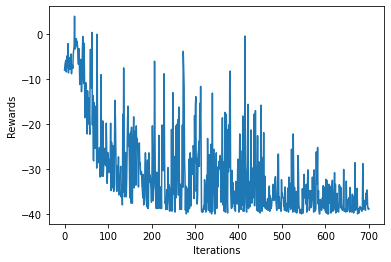

 70%|█████████████████████████████████████████████████████▉                       | 7012/10000 [16:15<04:29, 11.10it/s]

Mean Reward = -39.0
0


 70%|██████████████████████████████████████████████████████                       | 7022/10000 [16:16<04:28, 11.08it/s]

Mean Reward = -38.6
0


 70%|██████████████████████████████████████████████████████                       | 7028/10000 [16:16<04:28, 11.05it/s]

Updated Weights


 70%|██████████████████████████████████████████████████████▏                      | 7032/10000 [16:16<04:28, 11.05it/s]

Mean Reward = -38.4
0


 70%|██████████████████████████████████████████████████████▏                      | 7042/10000 [16:17<04:30, 10.93it/s]

Mean Reward = -39.8
0


 71%|██████████████████████████████████████████████████████▎                      | 7052/10000 [16:18<04:27, 11.02it/s]

Updated Weights
Mean Reward = -39.2
0


 71%|██████████████████████████████████████████████████████▍                      | 7064/10000 [16:19<03:49, 12.77it/s]

Mean Reward = -35.2
0


 71%|██████████████████████████████████████████████████████▍                      | 7072/10000 [16:20<04:14, 11.51it/s]

Mean Reward = -33.9
1


 71%|██████████████████████████████████████████████████████▌                      | 7078/10000 [16:20<04:21, 11.19it/s]

Updated Weights


 71%|██████████████████████████████████████████████████████▌                      | 7082/10000 [16:21<04:15, 11.43it/s]

Mean Reward = -39.0
0


 71%|██████████████████████████████████████████████████████▌                      | 7092/10000 [16:22<04:22, 11.07it/s]

Mean Reward = -33.4
0


 71%|██████████████████████████████████████████████████████▋                      | 7102/10000 [16:23<04:21, 11.10it/s]

Updated Weights
Mean Reward = -38.8
0


 71%|██████████████████████████████████████████████████████▊                      | 7112/10000 [16:24<04:21, 11.04it/s]

Mean Reward = -39.0
0


 71%|██████████████████████████████████████████████████████▊                      | 7122/10000 [16:24<04:19, 11.09it/s]

Mean Reward = -39.2
0


 71%|██████████████████████████████████████████████████████▉                      | 7128/10000 [16:25<04:20, 11.03it/s]

Updated Weights


 71%|██████████████████████████████████████████████████████▉                      | 7132/10000 [16:25<04:20, 10.99it/s]

Mean Reward = -39.4
0


 71%|██████████████████████████████████████████████████████▉                      | 7142/10000 [16:26<04:19, 11.02it/s]

Mean Reward = -38.8
0


 72%|███████████████████████████████████████████████████████                      | 7152/10000 [16:27<04:17, 11.07it/s]

Updated Weights
Mean Reward = -35.2
0


 72%|███████████████████████████████████████████████████████▏                     | 7162/10000 [16:28<03:57, 11.95it/s]

Mean Reward = -30.1
1


 72%|███████████████████████████████████████████████████████▏                     | 7172/10000 [16:29<04:08, 11.38it/s]

Mean Reward = -39.6
0


 72%|███████████████████████████████████████████████████████▎                     | 7178/10000 [16:29<04:16, 11.01it/s]

Updated Weights


 72%|███████████████████████████████████████████████████████▎                     | 7182/10000 [16:30<04:14, 11.06it/s]

Mean Reward = -35.2
0


 72%|███████████████████████████████████████████████████████▍                     | 7192/10000 [16:31<04:06, 11.40it/s]

Mean Reward = -39.4
0


 72%|███████████████████████████████████████████████████████▍                     | 7202/10000 [16:32<04:13, 11.03it/s]

Updated Weights
Mean Reward = -38.4
0


 72%|███████████████████████████████████████████████████████▌                     | 7212/10000 [16:32<04:05, 11.38it/s]

Mean Reward = -39.8
0


 72%|███████████████████████████████████████████████████████▌                     | 7222/10000 [16:33<04:09, 11.14it/s]

Mean Reward = -39.6
0


 72%|███████████████████████████████████████████████████████▋                     | 7227/10000 [16:34<03:48, 12.15it/s]

Updated Weights


 72%|███████████████████████████████████████████████████████▋                     | 7233/10000 [16:34<03:55, 11.77it/s]

Mean Reward = -34.3
1


 72%|███████████████████████████████████████████████████████▊                     | 7243/10000 [16:35<04:06, 11.18it/s]

Mean Reward = -39.6
0


 73%|███████████████████████████████████████████████████████▊                     | 7253/10000 [16:36<04:12, 10.87it/s]

Updated Weights
Mean Reward = -35.8
0


 73%|███████████████████████████████████████████████████████▉                     | 7262/10000 [16:37<05:03,  9.02it/s]

Mean Reward = -35.8
0


 73%|███████████████████████████████████████████████████████▉                     | 7272/10000 [16:38<05:40,  8.02it/s]

Mean Reward = -35.8
0


 73%|████████████████████████████████████████████████████████                     | 7277/10000 [16:39<05:37,  8.07it/s]

Updated Weights


 73%|████████████████████████████████████████████████████████                     | 7282/10000 [16:40<05:38,  8.04it/s]

Mean Reward = -35.4
0


 73%|████████████████████████████████████████████████████████▏                    | 7292/10000 [16:41<05:40,  7.96it/s]

Mean Reward = -36.2
0


 73%|████████████████████████████████████████████████████████▏                    | 7303/10000 [16:42<04:33,  9.85it/s]

Updated Weights
Mean Reward = -36.0
0


 73%|████████████████████████████████████████████████████████▎                    | 7312/10000 [16:43<04:16, 10.48it/s]

Mean Reward = -36.0
0


 73%|████████████████████████████████████████████████████████▍                    | 7322/10000 [16:44<04:47,  9.32it/s]

Mean Reward = -31.6
0


 73%|████████████████████████████████████████████████████████▍                    | 7327/10000 [16:44<04:59,  8.92it/s]

Updated Weights


 73%|████████████████████████████████████████████████████████▍                    | 7332/10000 [16:45<04:54,  9.07it/s]

Mean Reward = -32.0
0


 73%|████████████████████████████████████████████████████████▌                    | 7343/10000 [16:46<04:32,  9.75it/s]

Mean Reward = -39.2
0


 74%|████████████████████████████████████████████████████████▌                    | 7352/10000 [16:47<04:26,  9.95it/s]

Updated Weights
Mean Reward = -40.0
0


 74%|████████████████████████████████████████████████████████▋                    | 7362/10000 [16:48<04:39,  9.43it/s]

Mean Reward = -39.0
0


 74%|████████████████████████████████████████████████████████▊                    | 7373/10000 [16:49<04:27,  9.80it/s]

Mean Reward = -35.8
0


 74%|████████████████████████████████████████████████████████▊                    | 7377/10000 [16:50<05:07,  8.52it/s]

Updated Weights


 74%|████████████████████████████████████████████████████████▊                    | 7383/10000 [16:50<04:36,  9.45it/s]

Mean Reward = -31.2
0


 74%|████████████████████████████████████████████████████████▉                    | 7391/10000 [16:51<04:30,  9.65it/s]

Mean Reward = -35.6
0


 74%|████████████████████████████████████████████████████████▉                    | 7402/10000 [16:52<04:49,  8.98it/s]

Updated Weights
Mean Reward = -39.0
0


 74%|█████████████████████████████████████████████████████████                    | 7412/10000 [16:53<05:05,  8.47it/s]

Mean Reward = -39.6
0


 74%|█████████████████████████████████████████████████████████▏                   | 7422/10000 [16:54<04:44,  9.06it/s]

Mean Reward = -39.6
0


 74%|█████████████████████████████████████████████████████████▏                   | 7428/10000 [16:55<04:16, 10.01it/s]

Updated Weights


 74%|█████████████████████████████████████████████████████████▏                   | 7432/10000 [16:55<04:03, 10.54it/s]

Mean Reward = -39.0
0


 74%|█████████████████████████████████████████████████████████▎                   | 7442/10000 [16:56<04:09, 10.26it/s]

Mean Reward = -36.0
0


 75%|█████████████████████████████████████████████████████████▍                   | 7452/10000 [16:57<05:06,  8.31it/s]

Updated Weights
Mean Reward = -39.6
0


 75%|█████████████████████████████████████████████████████████▍                   | 7462/10000 [16:59<04:59,  8.46it/s]

Mean Reward = -39.2
0


 75%|█████████████████████████████████████████████████████████▌                   | 7472/10000 [17:00<04:48,  8.78it/s]

Mean Reward = -39.8
0


 75%|█████████████████████████████████████████████████████████▌                   | 7477/10000 [17:00<05:07,  8.21it/s]

Updated Weights


 75%|█████████████████████████████████████████████████████████▌                   | 7482/10000 [17:01<04:36,  9.11it/s]

Mean Reward = -40.0
0


 75%|█████████████████████████████████████████████████████████▋                   | 7492/10000 [17:02<05:24,  7.74it/s]

Mean Reward = -39.0
0


 75%|█████████████████████████████████████████████████████████▊                   | 7500/10000 [17:03<04:29,  9.28it/s]

Updated Weights
Mean Reward = -40.0
0


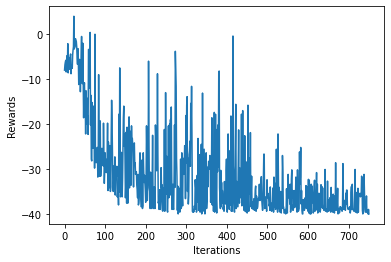

 75%|█████████████████████████████████████████████████████████▊                   | 7512/10000 [17:04<04:48,  8.62it/s]

Mean Reward = -30.3
1


 75%|█████████████████████████████████████████████████████████▉                   | 7522/10000 [17:05<04:25,  9.32it/s]

Mean Reward = -38.8
0


 75%|█████████████████████████████████████████████████████████▉                   | 7528/10000 [17:06<04:11,  9.84it/s]

Updated Weights


 75%|██████████████████████████████████████████████████████████                   | 7533/10000 [17:07<04:11,  9.83it/s]

Mean Reward = -38.4
0


 75%|██████████████████████████████████████████████████████████                   | 7543/10000 [17:07<03:42, 11.04it/s]

Mean Reward = -32.3
1


 76%|██████████████████████████████████████████████████████████▏                  | 7553/10000 [17:08<03:46, 10.81it/s]

Updated Weights
Mean Reward = -35.2
0


 76%|██████████████████████████████████████████████████████████▏                  | 7561/10000 [17:09<03:42, 10.96it/s]

Mean Reward = -35.6
0


 76%|██████████████████████████████████████████████████████████▎                  | 7572/10000 [17:10<05:02,  8.02it/s]

Mean Reward = -30.0
0


 76%|██████████████████████████████████████████████████████████▎                  | 7577/10000 [17:11<05:06,  7.91it/s]

Updated Weights


 76%|██████████████████████████████████████████████████████████▍                  | 7582/10000 [17:12<05:04,  7.94it/s]

Mean Reward = -38.8
0


 76%|██████████████████████████████████████████████████████████▍                  | 7592/10000 [17:13<04:49,  8.31it/s]

Mean Reward = -35.4
0


 76%|██████████████████████████████████████████████████████████▌                  | 7602/10000 [17:14<04:07,  9.68it/s]

Updated Weights
Mean Reward = -38.4
0


 76%|██████████████████████████████████████████████████████████▌                  | 7612/10000 [17:15<03:57, 10.07it/s]

Mean Reward = -35.4
0


 76%|██████████████████████████████████████████████████████████▋                  | 7622/10000 [17:16<03:43, 10.65it/s]

Mean Reward = -39.0
0


 76%|██████████████████████████████████████████████████████████▋                  | 7628/10000 [17:16<03:37, 10.91it/s]

Updated Weights


 76%|██████████████████████████████████████████████████████████▊                  | 7632/10000 [17:17<03:39, 10.81it/s]

Mean Reward = -39.4
0


 76%|██████████████████████████████████████████████████████████▊                  | 7642/10000 [17:18<03:34, 11.00it/s]

Mean Reward = -39.8
0


 77%|██████████████████████████████████████████████████████████▉                  | 7652/10000 [17:18<03:40, 10.64it/s]

Updated Weights
Mean Reward = -39.6
0


 77%|██████████████████████████████████████████████████████████▉                  | 7662/10000 [17:19<03:35, 10.85it/s]

Mean Reward = -33.2
0


 77%|███████████████████████████████████████████████████████████                  | 7672/10000 [17:20<03:38, 10.65it/s]

Mean Reward = -37.2
0


 77%|███████████████████████████████████████████████████████████                  | 7678/10000 [17:21<03:26, 11.23it/s]

Updated Weights


 77%|███████████████████████████████████████████████████████████▏                 | 7682/10000 [17:21<03:34, 10.83it/s]

Mean Reward = -39.6
0


 77%|███████████████████████████████████████████████████████████▏                 | 7692/10000 [17:22<03:35, 10.70it/s]

Mean Reward = -38.0
0


 77%|███████████████████████████████████████████████████████████▎                 | 7702/10000 [17:23<03:32, 10.83it/s]

Updated Weights
Mean Reward = -39.6
0


 77%|███████████████████████████████████████████████████████████▍                 | 7712/10000 [17:24<03:31, 10.81it/s]

Mean Reward = -34.8
0


 77%|███████████████████████████████████████████████████████████▍                 | 7723/10000 [17:25<03:32, 10.72it/s]

Mean Reward = -33.1
1


 77%|███████████████████████████████████████████████████████████▍                 | 7727/10000 [17:25<03:31, 10.76it/s]

Updated Weights


 77%|███████████████████████████████████████████████████████████▌                 | 7733/10000 [17:26<03:03, 12.38it/s]

Mean Reward = -39.4
0


 77%|███████████████████████████████████████████████████████████▌                 | 7741/10000 [17:27<03:32, 10.61it/s]

Mean Reward = -33.7
1


 78%|███████████████████████████████████████████████████████████▋                 | 7752/10000 [17:28<04:11,  8.95it/s]

Updated Weights
Mean Reward = -39.4
0


 78%|███████████████████████████████████████████████████████████▊                 | 7762/10000 [17:29<03:44,  9.96it/s]

Mean Reward = -39.0
0


 78%|███████████████████████████████████████████████████████████▊                 | 7772/10000 [17:30<03:16, 11.36it/s]

Mean Reward = -32.7
1


 78%|███████████████████████████████████████████████████████████▉                 | 7776/10000 [17:30<03:45,  9.88it/s]

Updated Weights


 78%|███████████████████████████████████████████████████████████▉                 | 7782/10000 [17:31<04:11,  8.80it/s]

Mean Reward = -38.4
0


 78%|███████████████████████████████████████████████████████████▉                 | 7792/10000 [17:32<04:31,  8.13it/s]

Mean Reward = -39.0
0


 78%|████████████████████████████████████████████████████████████                 | 7803/10000 [17:33<03:44,  9.78it/s]

Updated Weights
Mean Reward = -40.0
0


 78%|████████████████████████████████████████████████████████████▏                | 7811/10000 [17:34<03:29, 10.43it/s]

Mean Reward = -39.4
0


 78%|████████████████████████████████████████████████████████████▏                | 7822/10000 [17:35<03:27, 10.47it/s]

Mean Reward = -38.6
0


 78%|████████████████████████████████████████████████████████████▎                | 7828/10000 [17:36<03:24, 10.64it/s]

Updated Weights


 78%|████████████████████████████████████████████████████████████▎                | 7832/10000 [17:36<03:24, 10.62it/s]

Mean Reward = -37.4
0


 78%|████████████████████████████████████████████████████████████▍                | 7842/10000 [17:37<03:24, 10.53it/s]

Mean Reward = -39.0
0


 79%|████████████████████████████████████████████████████████████▍                | 7852/10000 [17:38<03:26, 10.39it/s]

Updated Weights
Mean Reward = -35.6
0


 79%|████████████████████████████████████████████████████████████▌                | 7864/10000 [17:39<02:58, 12.00it/s]

Mean Reward = -38.6
0


 79%|████████████████████████████████████████████████████████████▌                | 7872/10000 [17:40<03:14, 10.95it/s]

Mean Reward = -33.9
1


 79%|████████████████████████████████████████████████████████████▋                | 7876/10000 [17:40<03:20, 10.57it/s]

Updated Weights


 79%|████████████████████████████████████████████████████████████▋                | 7882/10000 [17:41<03:15, 10.82it/s]

Mean Reward = -39.2
0


 79%|████████████████████████████████████████████████████████████▊                | 7892/10000 [17:42<04:00,  8.76it/s]

Mean Reward = -38.6
0


 79%|████████████████████████████████████████████████████████████▊                | 7903/10000 [17:43<03:31,  9.90it/s]

Updated Weights
Mean Reward = -39.0
0


 79%|████████████████████████████████████████████████████████████▉                | 7913/10000 [17:44<03:23, 10.28it/s]

Mean Reward = -38.0
0


 79%|█████████████████████████████████████████████████████████████                | 7923/10000 [17:45<03:22, 10.26it/s]

Mean Reward = -36.6
0


 79%|█████████████████████████████████████████████████████████████                | 7927/10000 [17:45<03:18, 10.46it/s]

Updated Weights


 79%|█████████████████████████████████████████████████████████████                | 7931/10000 [17:46<03:12, 10.72it/s]

Mean Reward = -39.2
0


 79%|█████████████████████████████████████████████████████████████▏               | 7943/10000 [17:47<03:17, 10.39it/s]

Mean Reward = -39.2
0


 80%|█████████████████████████████████████████████████████████████▏               | 7953/10000 [17:48<03:20, 10.19it/s]

Updated Weights
Mean Reward = -39.0
0


 80%|█████████████████████████████████████████████████████████████▎               | 7963/10000 [17:49<03:15, 10.43it/s]

Mean Reward = -39.4
0


 80%|█████████████████████████████████████████████████████████████▍               | 7973/10000 [17:50<03:05, 10.94it/s]

Mean Reward = -39.2
0


 80%|█████████████████████████████████████████████████████████████▍               | 7977/10000 [17:50<03:07, 10.82it/s]

Updated Weights


 80%|█████████████████████████████████████████████████████████████▍               | 7983/10000 [17:51<03:02, 11.03it/s]

Mean Reward = -35.6
0


 80%|█████████████████████████████████████████████████████████████▌               | 7993/10000 [17:52<03:04, 10.86it/s]

Mean Reward = -39.2
0


 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [17:52<03:56,  8.46it/s]

Updated Weights
Mean Reward = -38.6
0


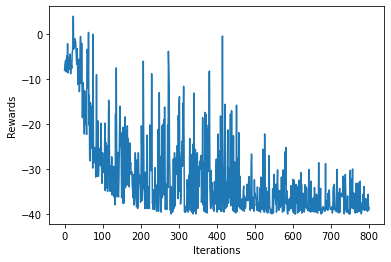

 80%|█████████████████████████████████████████████████████████████▋               | 8012/10000 [17:54<03:23,  9.75it/s]

Mean Reward = -37.0
0


 80%|█████████████████████████████████████████████████████████████▊               | 8022/10000 [17:55<02:56, 11.21it/s]

Mean Reward = -38.8
0


 80%|█████████████████████████████████████████████████████████████▊               | 8028/10000 [17:55<03:04, 10.70it/s]

Updated Weights


 80%|█████████████████████████████████████████████████████████████▊               | 8032/10000 [17:56<03:02, 10.79it/s]

Mean Reward = -38.8
0


 80%|█████████████████████████████████████████████████████████████▉               | 8044/10000 [17:57<02:34, 12.63it/s]

Mean Reward = -37.6
0


 81%|██████████████████████████████████████████████████████████████               | 8052/10000 [17:57<03:28,  9.34it/s]

Updated Weights
Mean Reward = -33.5
1


 81%|██████████████████████████████████████████████████████████████               | 8062/10000 [17:58<03:01, 10.70it/s]

Mean Reward = -39.8
0


 81%|██████████████████████████████████████████████████████████████▏              | 8072/10000 [17:59<03:07, 10.27it/s]

Mean Reward = -39.0
0


 81%|██████████████████████████████████████████████████████████████▏              | 8078/10000 [18:00<02:47, 11.50it/s]

Updated Weights


 81%|██████████████████████████████████████████████████████████████▏              | 8082/10000 [18:00<02:51, 11.18it/s]

Mean Reward = -33.6
1


 81%|██████████████████████████████████████████████████████████████▎              | 8092/10000 [18:01<02:53, 10.97it/s]

Mean Reward = -38.2
0


 81%|██████████████████████████████████████████████████████████████▍              | 8102/10000 [18:02<02:59, 10.59it/s]

Updated Weights
Mean Reward = -33.2
0


 81%|██████████████████████████████████████████████████████████████▍              | 8114/10000 [18:03<02:40, 11.75it/s]

Mean Reward = -39.4
0


 81%|██████████████████████████████████████████████████████████████▌              | 8122/10000 [18:04<02:53, 10.81it/s]

Mean Reward = -30.5
1


 81%|██████████████████████████████████████████████████████████████▌              | 8126/10000 [18:04<03:03, 10.23it/s]

Updated Weights


 81%|██████████████████████████████████████████████████████████████▌              | 8132/10000 [18:05<03:01, 10.29it/s]

Mean Reward = -39.8
0


 81%|██████████████████████████████████████████████████████████████▋              | 8142/10000 [18:06<02:49, 10.95it/s]

Mean Reward = -39.4
0


 82%|██████████████████████████████████████████████████████████████▊              | 8152/10000 [18:07<02:47, 11.01it/s]

Updated Weights
Mean Reward = -39.2
0


 82%|██████████████████████████████████████████████████████████████▊              | 8162/10000 [18:08<03:00, 10.18it/s]

Mean Reward = -40.0
0


 82%|██████████████████████████████████████████████████████████████▉              | 8172/10000 [18:09<02:55, 10.44it/s]

Mean Reward = -39.0
0


 82%|██████████████████████████████████████████████████████████████▉              | 8178/10000 [18:09<02:58, 10.21it/s]

Updated Weights


 82%|███████████████████████████████████████████████████████████████              | 8182/10000 [18:10<03:22,  8.96it/s]

Mean Reward = -39.6
0


 82%|███████████████████████████████████████████████████████████████              | 8192/10000 [18:11<03:30,  8.60it/s]

Mean Reward = -39.4
0


 82%|███████████████████████████████████████████████████████████████▏             | 8202/10000 [18:12<03:57,  7.58it/s]

Updated Weights
Mean Reward = -39.4
0


 82%|███████████████████████████████████████████████████████████████▏             | 8212/10000 [18:13<03:52,  7.68it/s]

Mean Reward = -39.8
0


 82%|███████████████████████████████████████████████████████████████▎             | 8222/10000 [18:15<03:46,  7.85it/s]

Mean Reward = -39.4
0


 82%|███████████████████████████████████████████████████████████████▎             | 8227/10000 [18:15<03:34,  8.26it/s]

Updated Weights


 82%|███████████████████████████████████████████████████████████████▍             | 8233/10000 [18:16<03:03,  9.62it/s]

Mean Reward = -35.6
0


 82%|███████████████████████████████████████████████████████████████▍             | 8242/10000 [18:17<03:28,  8.44it/s]

Mean Reward = -39.6
0


 83%|███████████████████████████████████████████████████████████████▌             | 8252/10000 [18:18<03:37,  8.03it/s]

Updated Weights
Mean Reward = -39.8
0


 83%|███████████████████████████████████████████████████████████████▌             | 8262/10000 [18:19<03:29,  8.29it/s]

Mean Reward = -25.9
1


 83%|███████████████████████████████████████████████████████████████▋             | 8272/10000 [18:21<03:25,  8.42it/s]

Mean Reward = -35.8
0


 83%|███████████████████████████████████████████████████████████████▋             | 8277/10000 [18:21<03:05,  9.28it/s]

Updated Weights


 83%|███████████████████████████████████████████████████████████████▊             | 8282/10000 [18:22<03:05,  9.24it/s]

Mean Reward = -39.8
0


 83%|███████████████████████████████████████████████████████████████▊             | 8286/10000 [18:22<03:48,  7.51it/s]


KeyboardInterrupt: 

In [5]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(10000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%25==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    
    if epoch>50 and epoch%50==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9
#         print(user_agent.replay_buffer.state_history[5])
#         print(user_agent.replay_buffer.action_history[5])
#         print(user_agent.replay_buffer.rewards_history[5])
#         print(user_agent.replay_buffer.next_state_history[5])

    mean_rewards.append(episode_reward)
    if epoch%10==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [6]:
user_agent.model(np.array([[0.1, 0.1, 0.1 , 0.3]]))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-9.582598, -9.564746, -9.420624, -9.387526]], dtype=float32)>

In [7]:
mod_agent.model(np.array([[0, 1, 0, 0, 0.1, 0.1]]))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-9.417702, -9.37699 , -9.389755, -9.297197]], dtype=float32)>